# Teoria uczenia maszynowego - Projekt zaliczeniowy

- Daniel Zdancewicz [indeks: 145317]
- Repozytorium z pełnym źródłem projektu: https://github.com/Mimikkk/2024-tum

## Temat:

Wpływ dodawania szumu na trafność algorytmów uczenia. 

## Opis:

Celem projektu jest zbadanie wpływu dodawania szumu na trafność algorytmów uczenia maszynowego.
Szum jest dodawany do zbioru uczącego poprzez:

- dodanie dodatkowych cech wejściowych z szumem.
- zaszumienie istniejących cech.
- zaszumienie wartości na wyjściu.

## Plan realizacji i wybory projektowe:

1. Wybór zbioru danych:
    - zbiór danych "Iris" dostępny w bibliotece sklearn.datasets
    - zbiór danych "Wine" dostępny w bibliotece sklearn.datasets
2. Implementacja algorytmów uczenia maszynowego
    - Wykorzystano algorytmy: SVM, KNN, Random Forest, oraz prostą sieć neuronową MLP
    - Zaimplementowano funkcję, która zwraca trafność klasyfikacji dla zbioru danych
3. Implementacja sposobów dodawania szumu
    - Dodawanie szumu nowych cech wejściowych ze stałym szumem
    - Dodawanie szumu nowych cech wejściowych ze skorelowanym szumem
    - Dodawanie szumu do istniejących cech wejściowych ze stałym szumem
    - Dodawanie szumu do istniejących cech wejściowych ze skorelowanym szumem
    - Dodawanie szumu na wyjściu (losowe zmiany etykiet klas w części obiektów)
4. Zbadanie wpływu dodawania szumu na trafność algorytmów uczenia maszynowego
    - Zaimplementowano funkcję, która dodaje szum do zbioru danych, wewnątrz obrębu danych uczących, ale nie testowych.
    - Zbadano wpływu dodania szumu na trafność klasyfikacji dla różnych algorytmów uczenia maszynowego
5. Eksperymenty
6. Wyniki
7. Przedstawienie wniosków

### Założenia o wynikach:
- Dodanie szumu do zbioru danych prawdopodobnie obniży trafność klasyfikacji.
- Dodanie szumu do wyjść bardzo prawdopodobnie obniży trafność klasyfikacji ze względu na niepoprawność klas.
- Prawdopodobnie trafność klasyfikacji może zostać przywrócona poprzez zastosowanie odpowiednich technik regularyzacji, np PCA, L1, L2.

## Importy bibliotek i modułów

In [39]:
from analysis import visualize_correlation, visualize_metrics
from experiments import summarize_results, run_experiments, create_model_descriptors
from datasets.utils import load_datasets, create_noisy_datasets
from datasets import DatasetNoise


## Wczytanie zbiorów danych

In [40]:
iris, wine = load_datasets()


### Zbiór danych "Iris"

Zbiór składający się z 150 próbek trzech gatunków irysów (Iris setosa, Iris virginica, Iris versicolor). 

Dla każdego irysa mamy 4 cechy: długość i szerokość płatków oraz długość i szerokość działki kielicha.

Wszystkie te wartości są wartościami liczbowymi, założyłem dodatkową walidację wewnątrz klasy `IrisDataset` sprawdzającą czy wartości są liczbami.

Zbiór ten jest dosyć mały i ma mało cech, służył mi jako zbiór do testów i weryfikacji poprawności implementacji.

In [41]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Zbiór danych "Wine"

Zbiór składający się z 178 próbek trzech gatunków win (klasy 0, 1, 2).

Dla każdego wina mamy 13 cech:
- Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline

Wszystkie są również wartościami liczbowymi, i również założyłem dodatkową walidację wewnątrz klasy `WineDataset` sprawdzającą czy wartości są liczbami.

Ten zbiór jest większy i ma więcej cech przez co pozwala na bardziej złożone eksperymenty.

In [42]:
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## Algorytmy uczenia maszynowego

Skorzystałem z gotowych implementacji algorytmów dostępnych w bibliotece `scikit-learn`.

Wykorzystuje z niej algorytmy:
- SVM, KNN, RandomForest oraz prostą sieć MLP.
- KNN dałem w 3 wariantach z różną ilością sąsiadów ( 2, 3, 4 ).

Implementacja algorytmów znajduje się w metodzie `create_model_descriptors`, która zwraca fabryki modeli z odpowiednimi labelkami.


In [43]:
descriptors = create_model_descriptors()

## Algorytmy zaszumienia danych

Do zaszumienia danych utworzyłem klasę `DatasetNoise` która pozwala na dodanie szumu do zbioru danych za pomocą 4 algorytmów. Podczas eksperymentów szumowanie danych odbywa się wewnątrz zbioru uczącego, ale nie testowego.


### Pomocnicze funkcje do wizualizacji różnic

In [44]:
from raport.display import render_difference, pick_first_column_id, pick_second_column_id

In [45]:
column_id = pick_first_column_id(iris)
clean = iris.head()

## Dodanie stałego szumu do kolumny

Metody `add_static_noise/add_static_noises` - dodają szum do kolumny na podstawie różnicy maksymalnej i minimalnej wartości pomnożonej przez współczynnik skalowania.

In [46]:
noisy_static = DatasetNoise(iris).add_static_noise(column_id, 0.1).build().head()

render_difference(clean, noisy_static, column_id=column_id, title="Stały szum w skali 0.1")


,sepal_length
0,5.1
1,4.9
2,4.7
3,4.6
4,5.0
,sepal_length
0,0.36
1,0.36
2,0.36
3,0.36


## Dodanie losowego szumu do kolumny

Metody `add_random_noise/add_random_noises` - dodają losowy szum do kolumny na podstawie różnicy maksymalnej i minimalnej wartości pomnożonej przez współczynnik skalowania próbkowany z rand(scale_min, scale_max).

In [47]:
noisy_random = DatasetNoise(iris).add_random_noise(column_id, (0.0, 0.2)).build().head()

render_difference(clean, noisy_random, column_id=column_id, title="Losowy szum w skali (0.0, 0.2)")

,sepal_length
0,5.1
1,4.9
2,4.7
3,4.6
4,5.0
,sepal_length
0,0.484862
1,0.079787
2,0.083910
3,0.060073


## Dodanie stałego skorelowanego szumu do kolumny

Metody `add_static_correlated_noise/add_static_correlated_noises` - dodają skorelowany szum do kolumny na podstawie różnicy maksymalnej i minimalnej wartości pomnożonej przez normy wskazanej kolumny.

In [48]:
first_column_id = pick_first_column_id(iris)
second_column_id = pick_second_column_id(iris)
column_ids = [first_column_id, second_column_id]

noisy_correlated_static = (
  DatasetNoise(iris)
  .add_static_correlated_noise(first_column_id, second_column_id)
  .build()
  .head()
)

render_difference(clean, noisy_correlated_static, column_ids=column_ids, title="Stały skorelowany szum")

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
,sepal_length,sepal_width
0,2.25,0.0
1,1.50,0.0
2,1.80,0.0
3,1.65,0.0


## Dodanie losowego skorelowanego szumu do kolumny

Metody `add_random_correlated_noise/add_random_correlated_noises` - dodają skorelowany szum do kolumny na podstawie różnicy maksymalnej i minimalnej wartości pomnożonej przez normy wskazanej kolumny próbkowany z rand(scale_min, scale_max).


In [49]:
noisy_correlated_random = (
  DatasetNoise(iris)
  .add_random_correlated_noise(first_column_id, second_column_id, (0.0, 0.2))
  .build()
  .head()
)

render_difference(clean, noisy_correlated_random, column_ids=column_ids,
                  title="Losowy skorelowany szum w skali (0.0, 0.2)")

,sepal_length,sepal_width
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
,sepal_length,sepal_width
0,2.311468,0.0
1,2.812204,0.0
2,0.838571,0.0
3,1.797923,0.0


## Dodanie szumu do wyjścia

Metoda `shuffle` - Miesza wskazany procent etykiet klas w zbiorze danych w obrębie wskazanej kolumny.

In [50]:
def pick_last_column_id(dataset):
  return dataset.columns[-1]

target_column_id = pick_last_column_id(iris)

noisy_output = DatasetNoise(iris).shuffle(target_column_id, percentage=1.0).build().head()

render_difference(clean, noisy_output, column_id=target_column_id, title="Szum na wyjściu po przemieszaniu etykiet")

,target
0,0
1,0
2,0
3,0
4,0
,target
0,2
1,2
2,1
3,1


## Eksperymenty

Eksperymenty polegały na zbadaniu wpływu dodawania szumu na różnych metrykach dla różnych algorytmów uczenia maszynowego.

Implementacja przebiegu eksperymentu jest opisany wewnątrz metody `run_experiments`, a sposób jego podsumowania wewnątrz metody `summarize_results`. Podobnie metody wizualizacji są wewnątrz metody `visualize_metrics` oraz `visualize_correlation`.

Sposób wytworzenia zaszumionych zbiorów danych znajduje się w metodzie `create_noisy_datasets`, która przechodzi przez parametryzację tworzonych szumów. Parametry to:
- `dataset` - zbiór danych do zaszumienia
  - `iris` - zbiór danych "Iris"
  - `wine` - zbiór danych "Wine"
- `use_create_noise_input` - czy użyć nowych kolumn szumu na wejściu
  - Tak/Nie
- `random_input_type` -  rodzaj szumu na wejściu
  - `static` - stały szum
  - `random` - losowy szum
  - `corr-static` - stały skorelowany szum
  - `corr-random` - losowy skorelowany szum ( random column )
- `random_input_scale` - skalowanie szumu na wejściu ( random column )
  - (0.1, 0.25, 0.75) 
- `random_input_count` - ilość nowych zaszumionych kolumn na wejściu
  - (1, 2, 3)
- `use_modify_noise_input` - czy użyć modyfikowanych kolumn szumem na wejściu ( random )
  - Tak/Nie
- `modified_input_type` -  rodzaj szumu na wejściu
  - `static` - stały szum
  - `random` - losowy szum
  - `corr-static` - stały skorelowany szum
  - `corr-random` - losowy skorelowany szum
- `modified_input_scale` - skalowanie szumu na wejściu
  - (0.1, 0.25, 0.75) 
- `use_noise_output` - czy użyć szumu na wyjściu
  - Tak/Nie
- `random_output_scale` - skala przemieszania etykiet na wyjściu
  - (0.1, 0.25, 0.75) 

Przy wyborze kolumn do korelacji, nie mogą być powtórzone, ani target.

Niektóre kombinacje są powtórzeniami, ze względu na to, że niektóre parametry nie występują w parach, te pary są pomijane na podstawie unikalności ich klucza, który można zobaczyć wewnątrz metody `create_noisy_datasets`.
W efekcie jest 952 kombinacji eksperymentów.

Uruchomienie eksperymentów dzieje się poprzez wywołanie metody `run_experiment` na wszystkich parach dostępnych modeli i utworzonych zbiorach w ramach modyfikacji danych. 

In [51]:
RunCount = 50

iris, wine = load_datasets()
datasets = create_noisy_datasets(iris, wine)

results = run_experiments(datasets, descriptors, run_count=RunCount)

## Wyniki

Wyniki są monadem agregrującym wyniki z eksperymentów. Zawiera on informacje o wynikach dla każdego modelu, dla każdego zbioru danych, dla każdego rodzaju szumu.
- Wynik składa się z metryk: accuracy, precision, recall, confusion, które zawierają odpowiednie wartości dla każdego modelu.
- W poszczególnych metrykach znajdują się wyniki dla każdego eksperymentu, ich medianie, średniej, odchylenia standardowego oraz minimalnej i maksymalnej wartości.

In [52]:
summary = summarize_results(results)


In [53]:
datasets = [*{key.split(':')[0].split('_', 1)[0] for key in summary}]
models = [*{key.split(':')[-1] for key in summary}]


## Wizualizacja wyników

Wizualizacja wyników polega na przedstawieniu wyników w postaci tabeli oraz wykresów. Implementacja wewnątrz metody `visualize_metrics`.

Do raportu przedstawiam tylko metrykę `accuracy` i `confusion` z powodu ograniczeń miejsca. W metodzie `visualize_metrics`. wystarczyłoby zmienić wartość `metric` na inną wartość z listy. z powodu czytelności zamieszczam wykresy z tylko częścią (6 wyników i model bez szumu).

Datasets: ['wine', 'iris']
  - Dataset: wine
    - Model: SVC


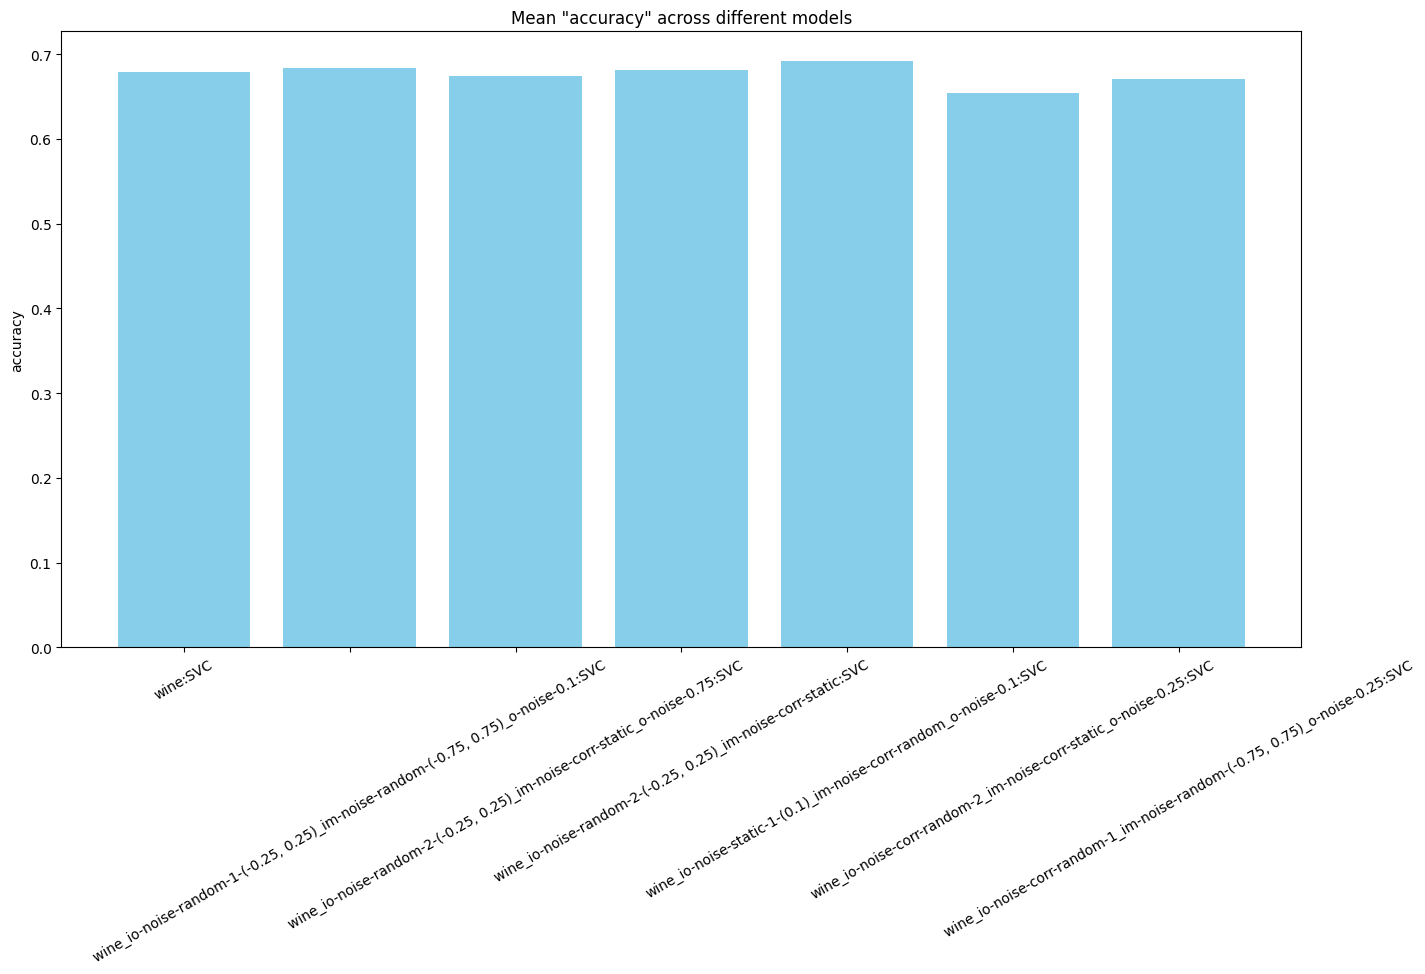

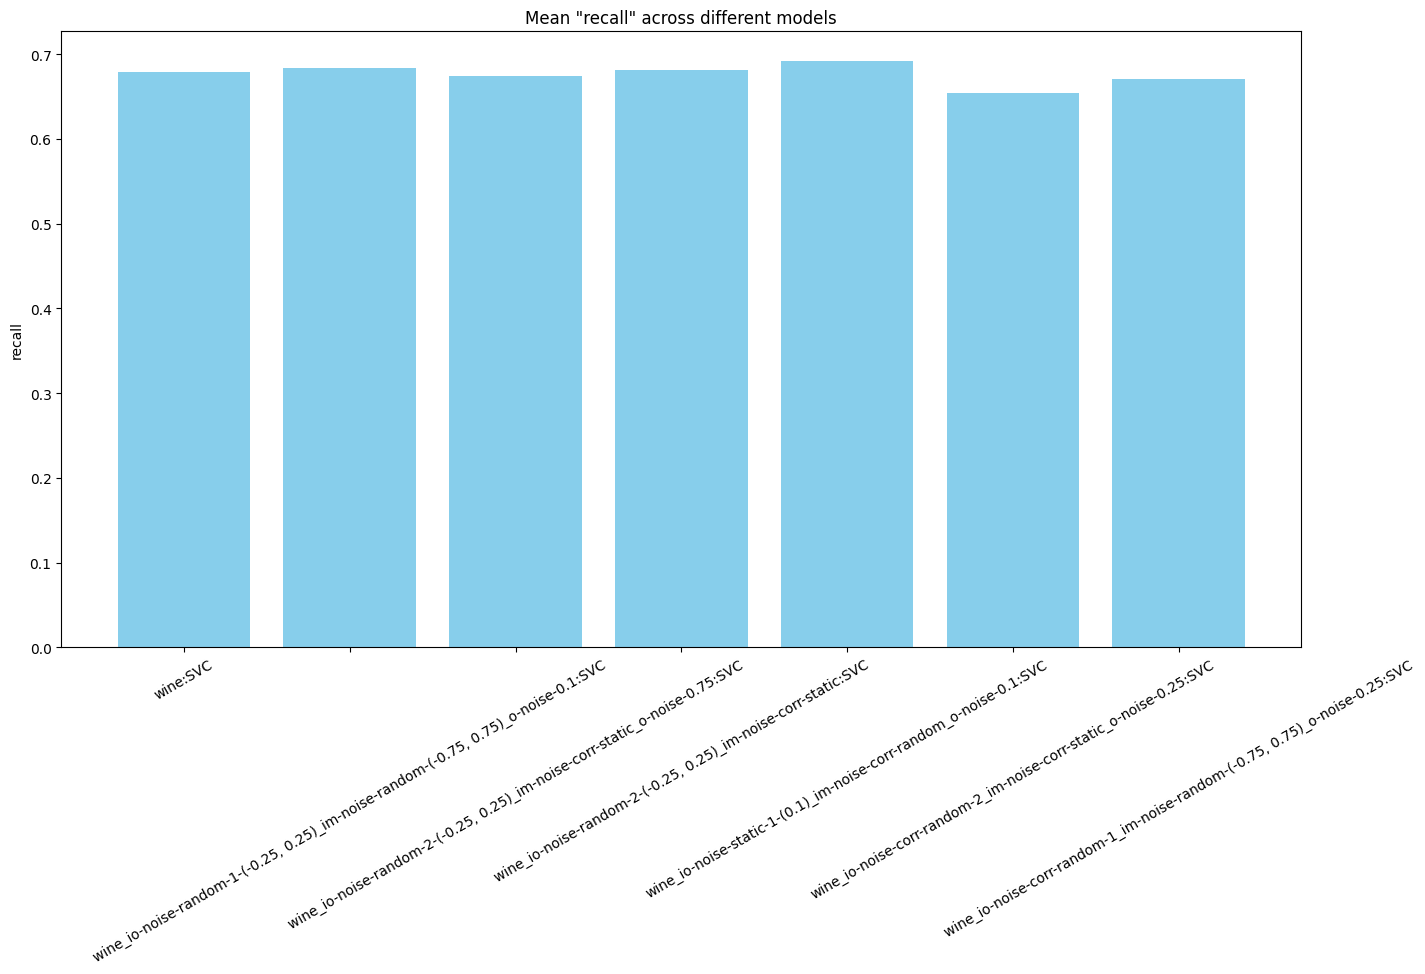

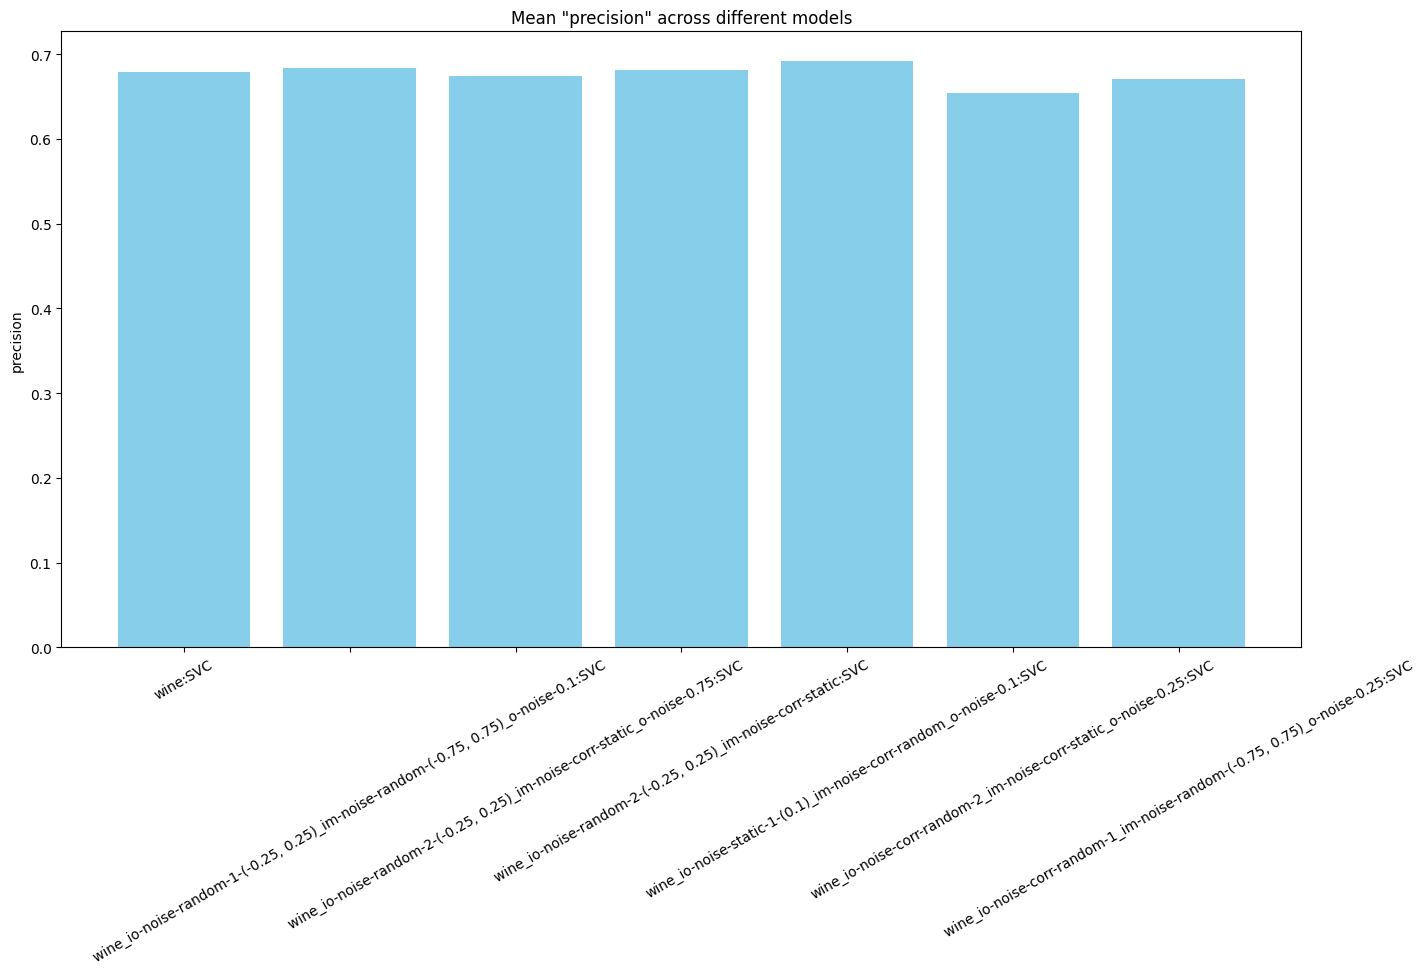

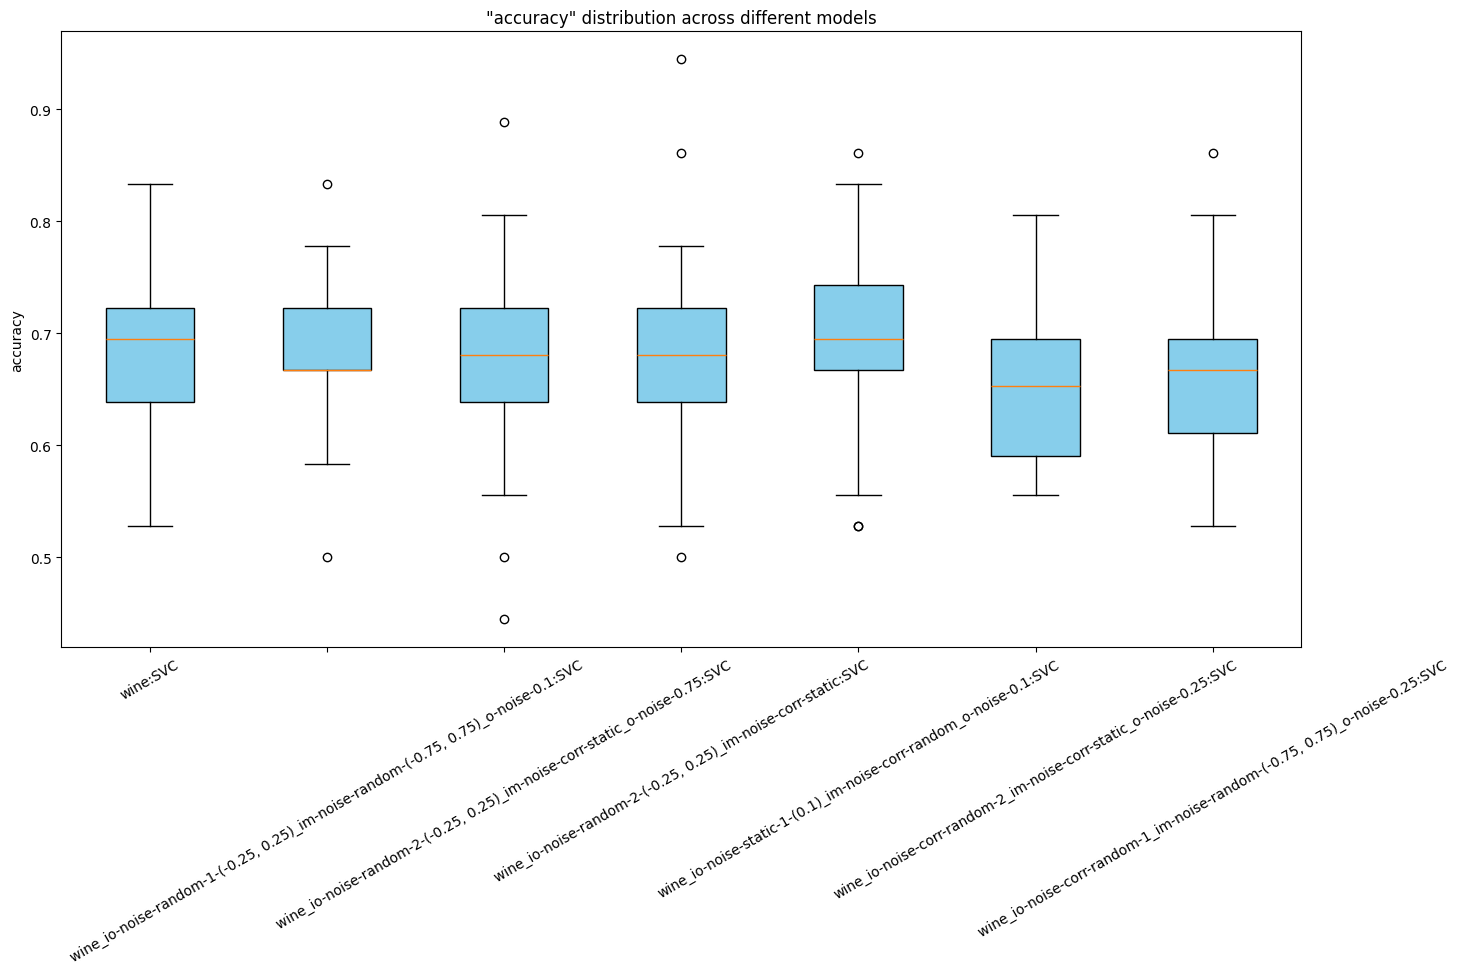

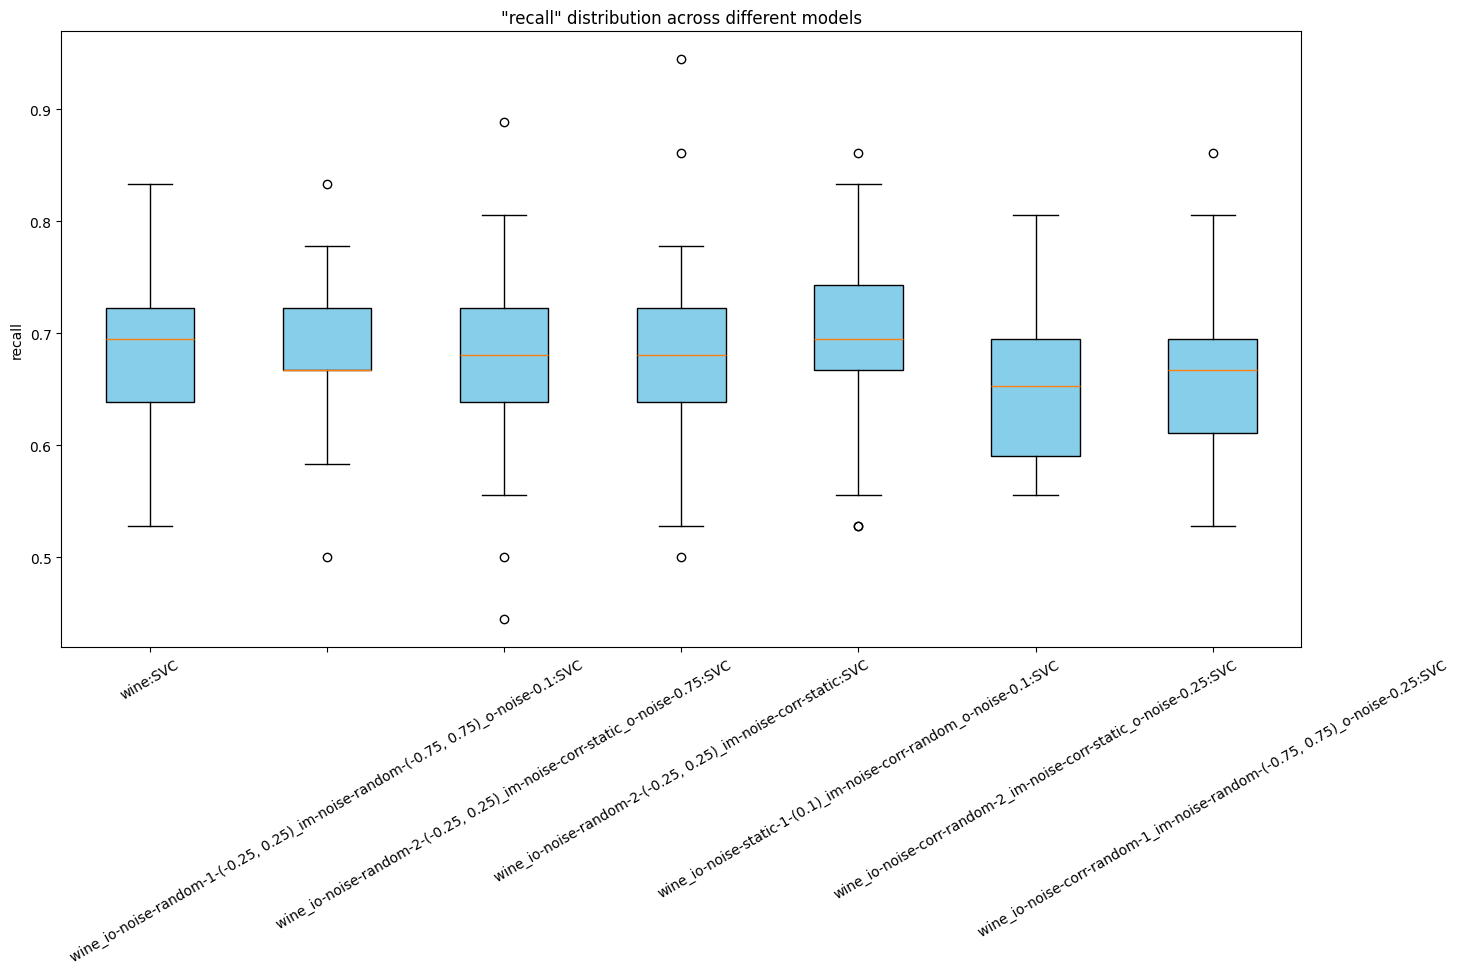

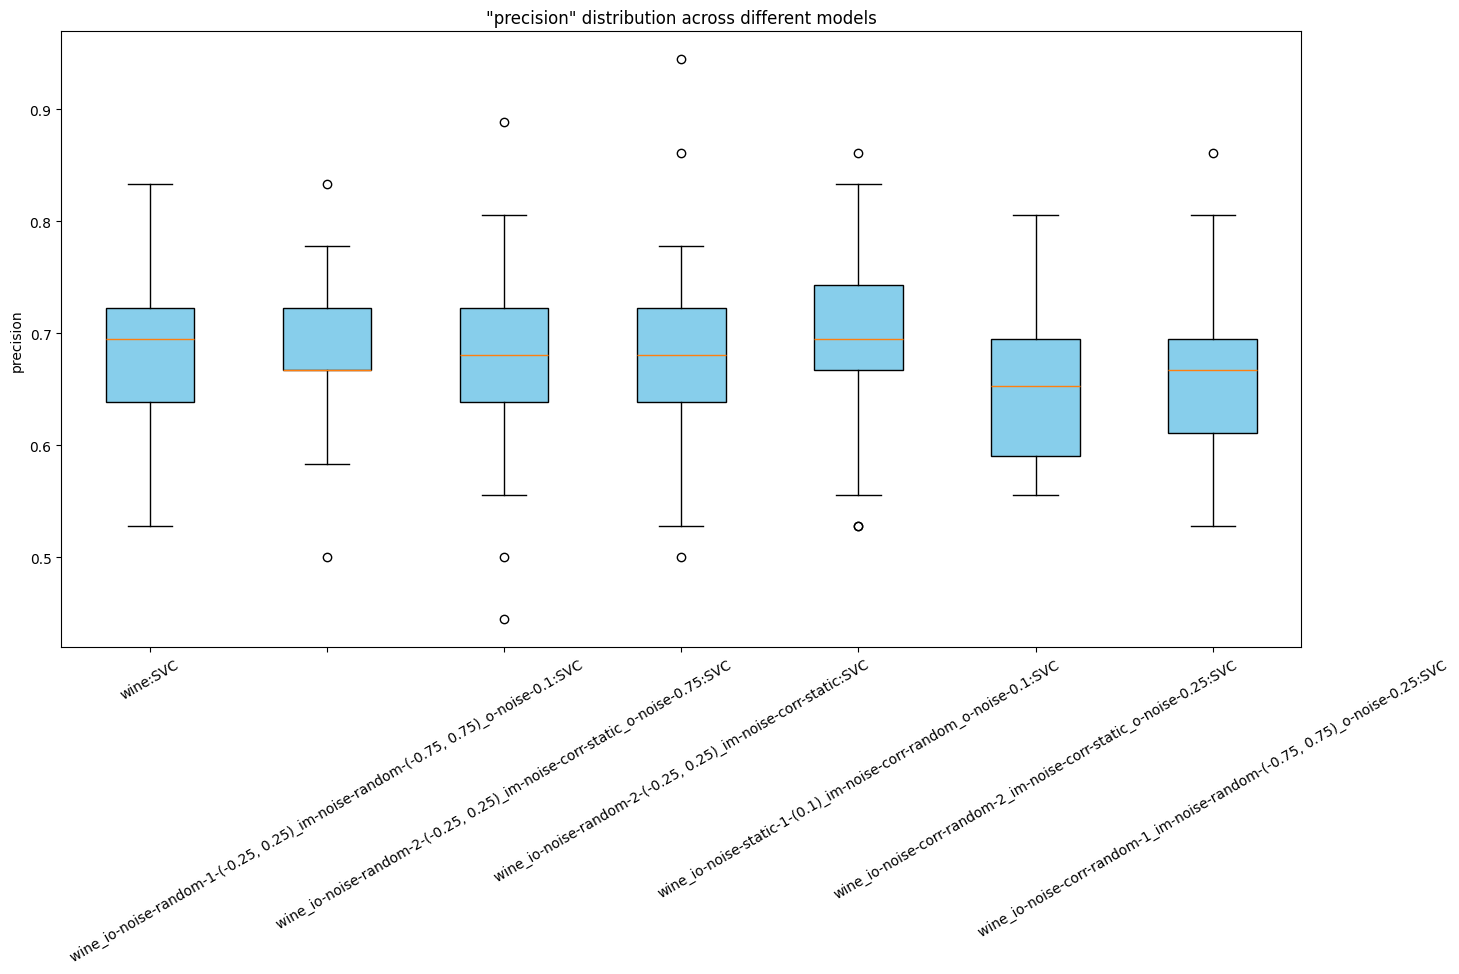

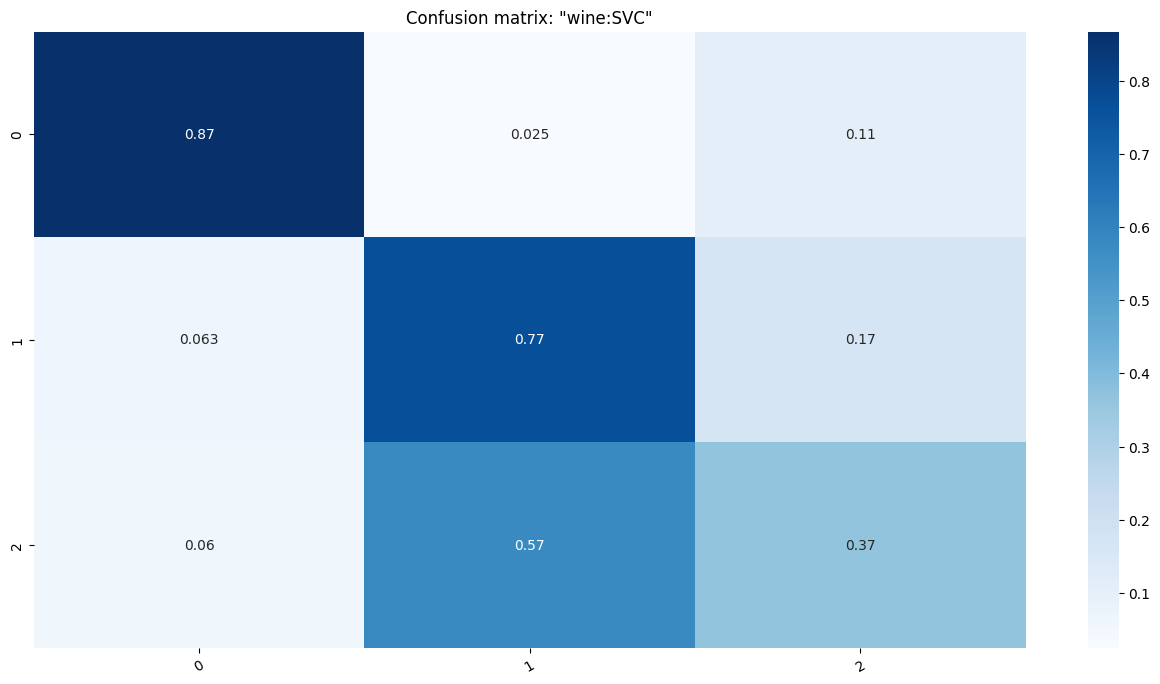

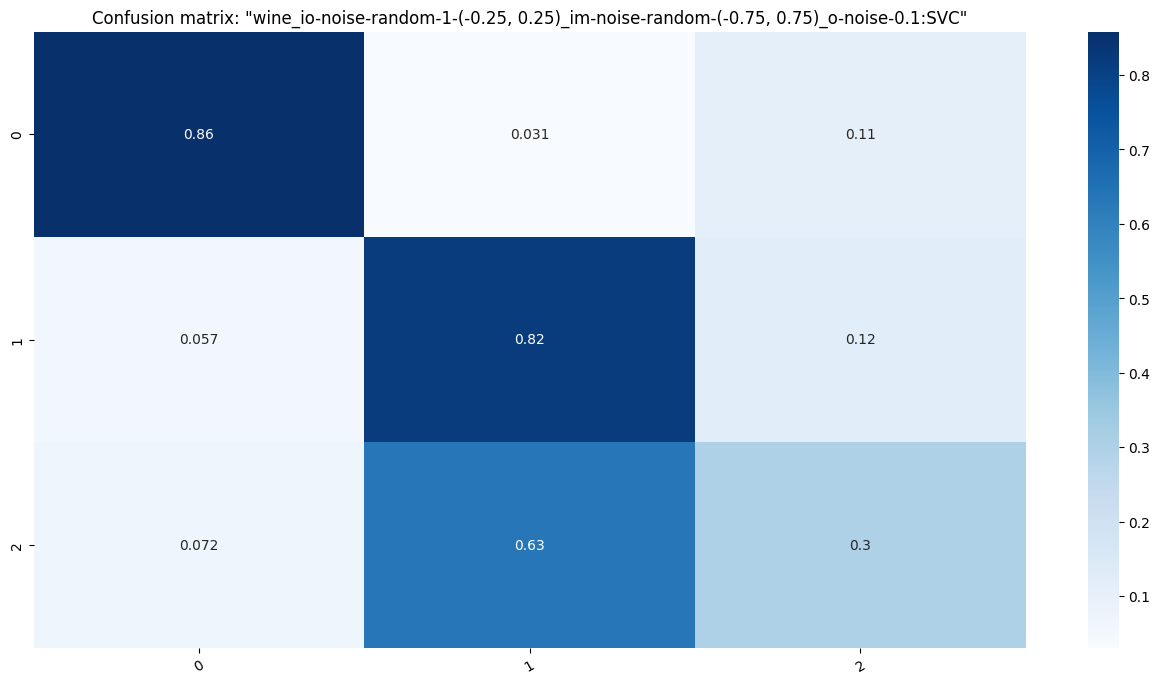

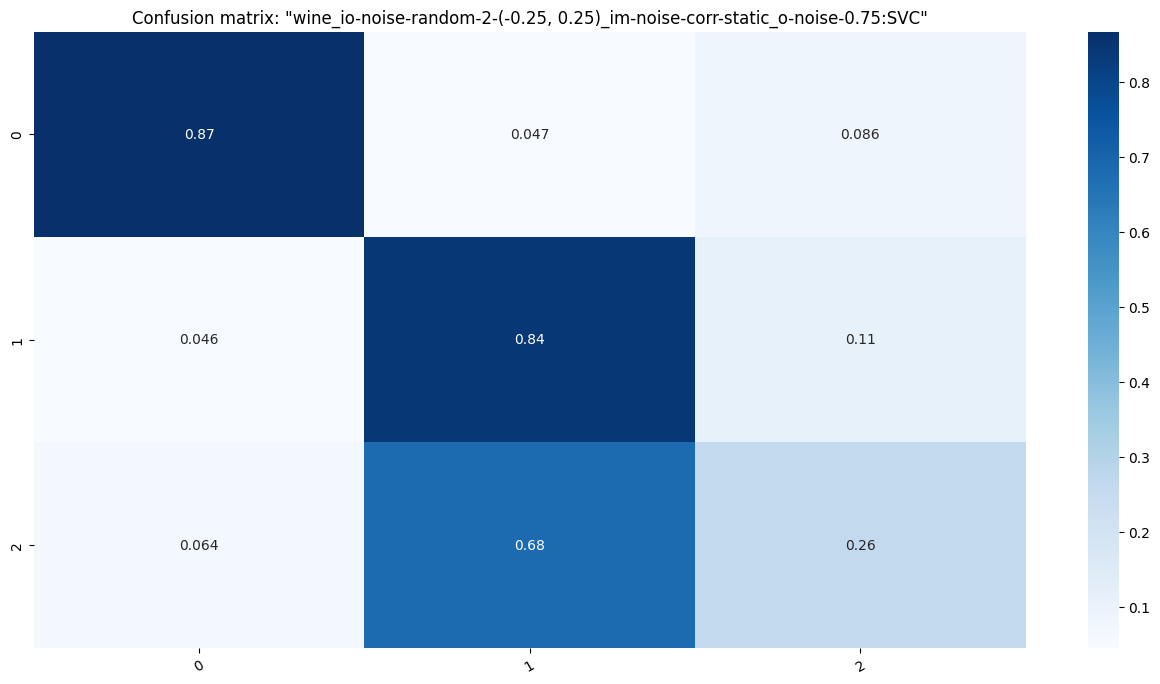

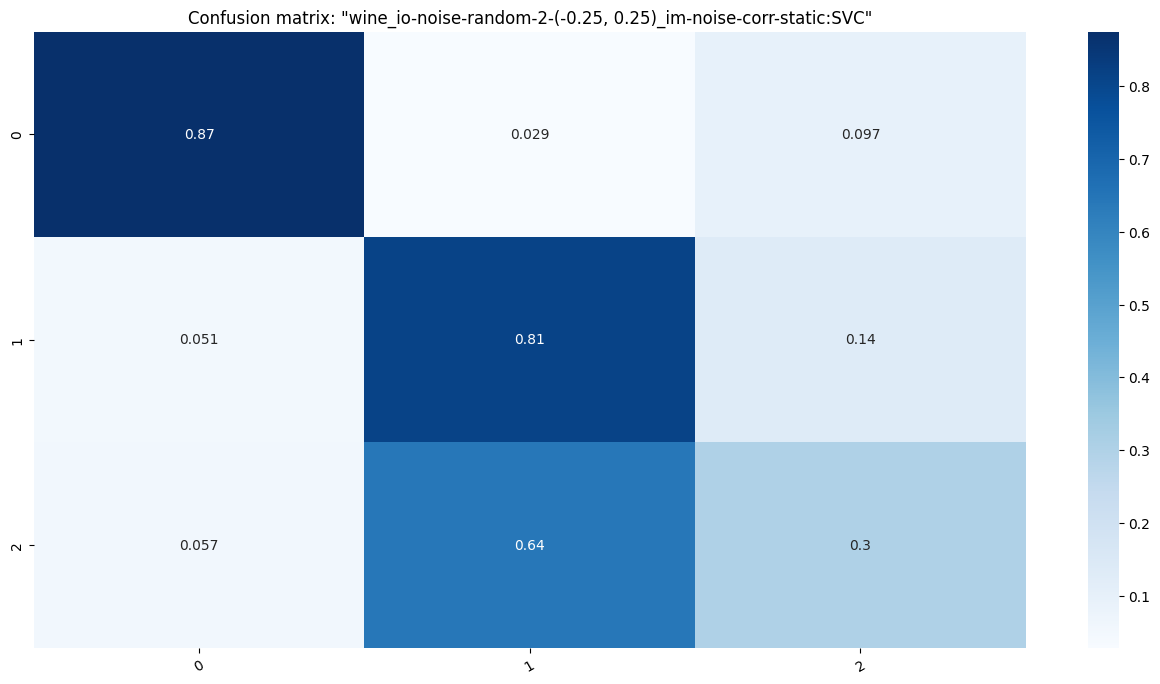

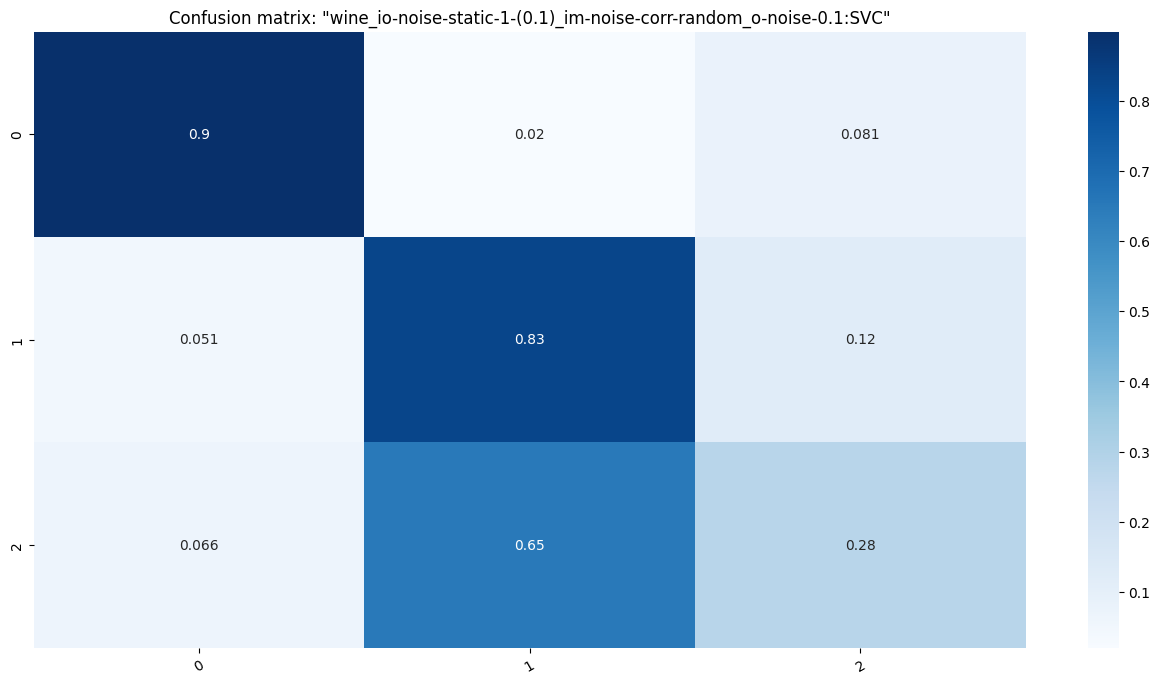

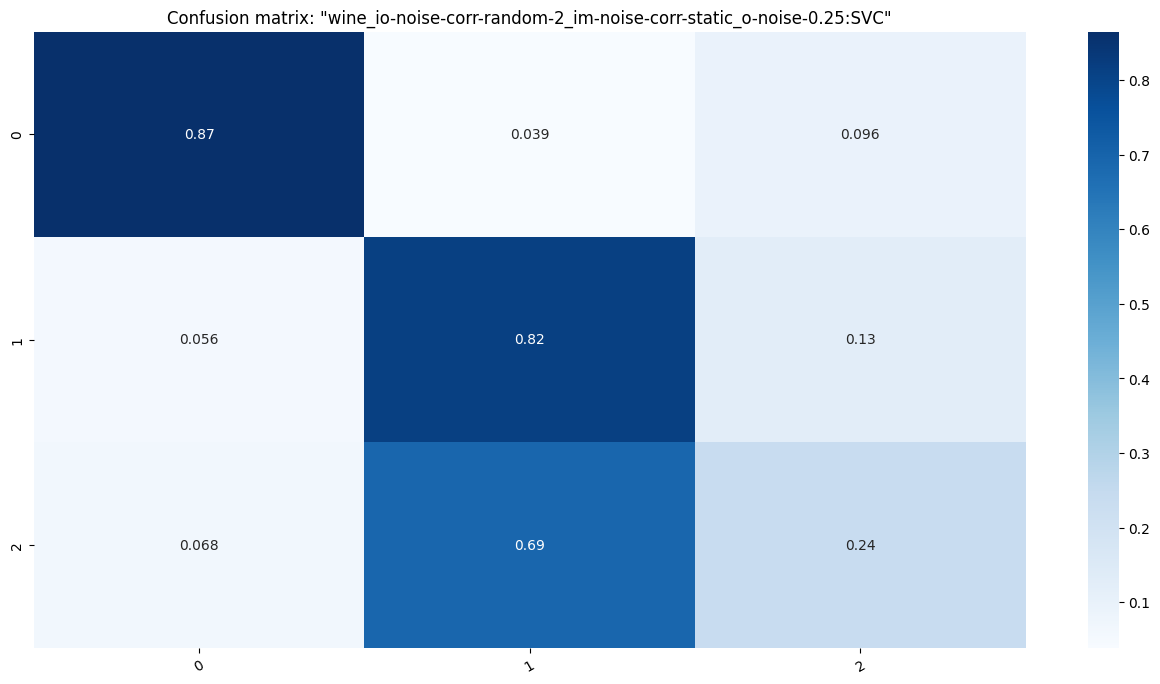

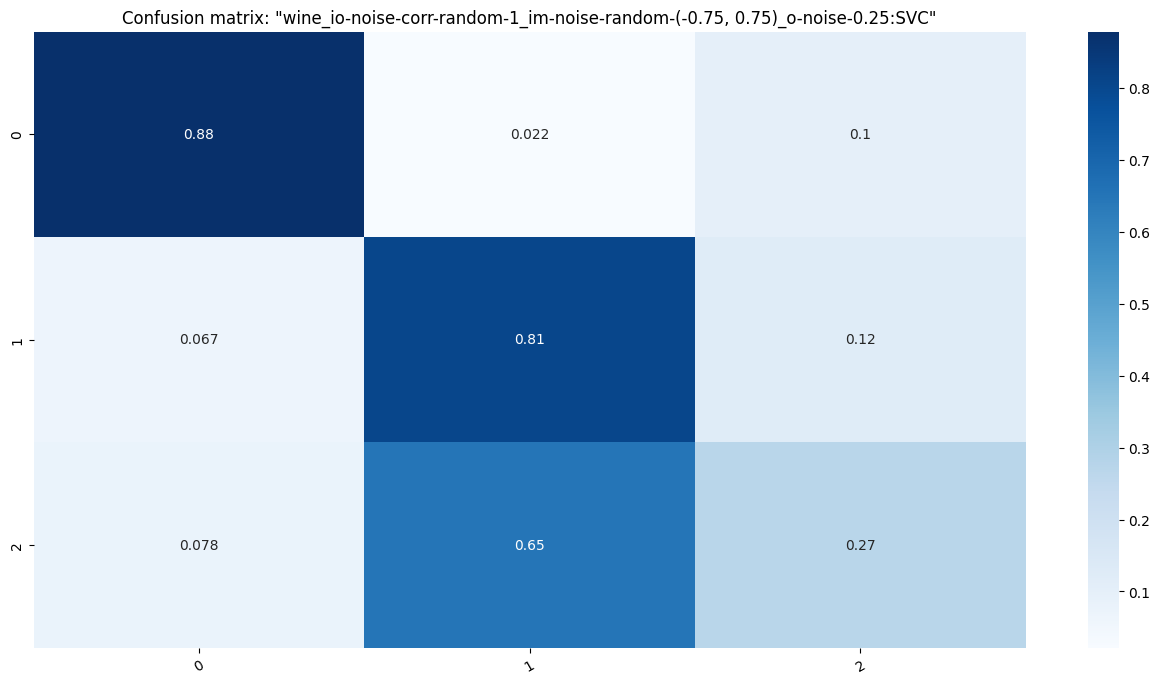

  - Dataset: iris
    - Model: SVC


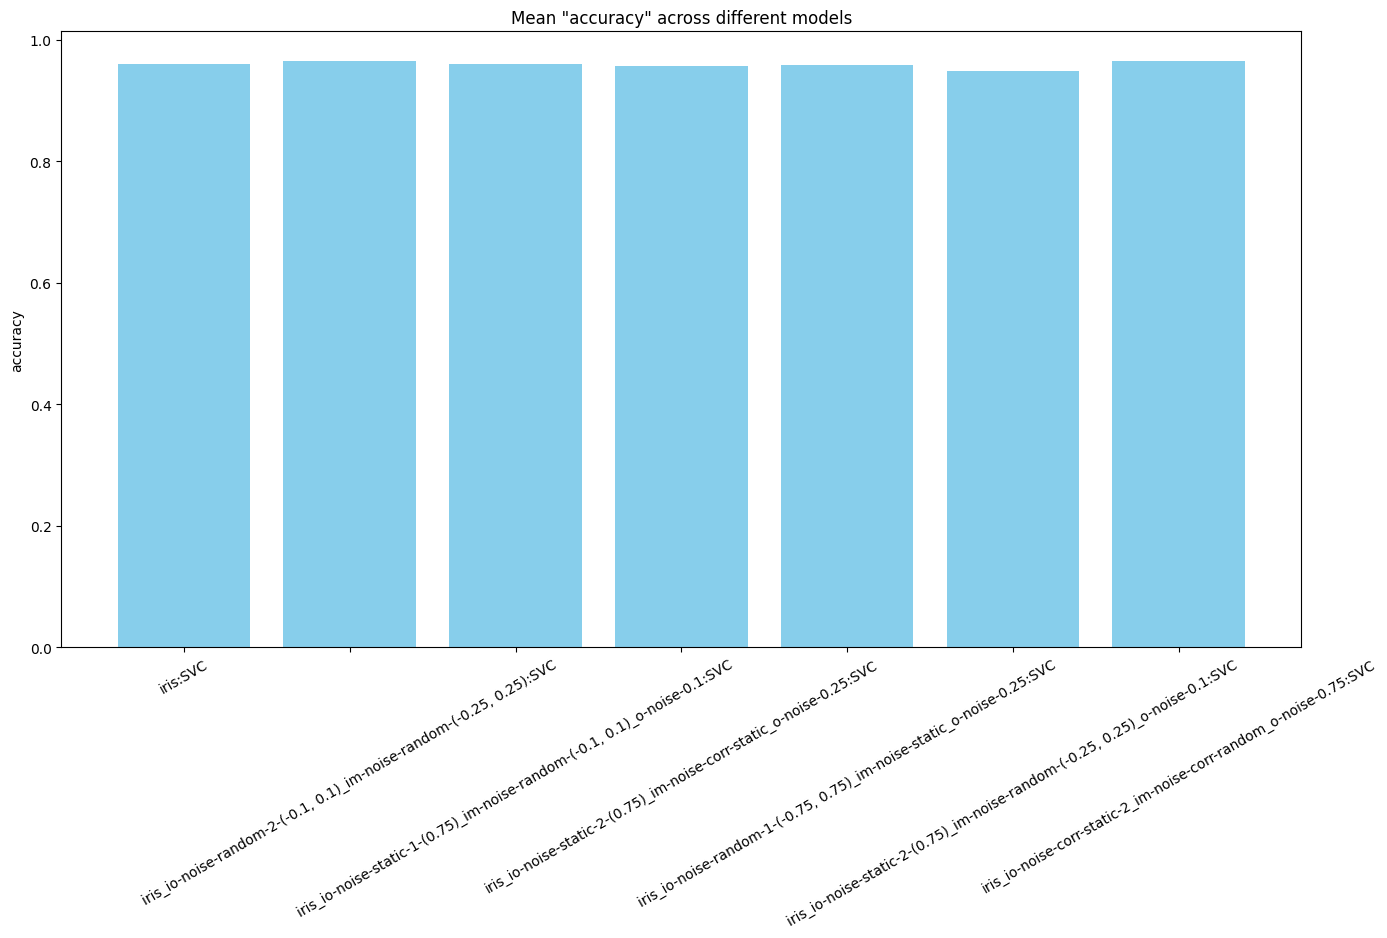

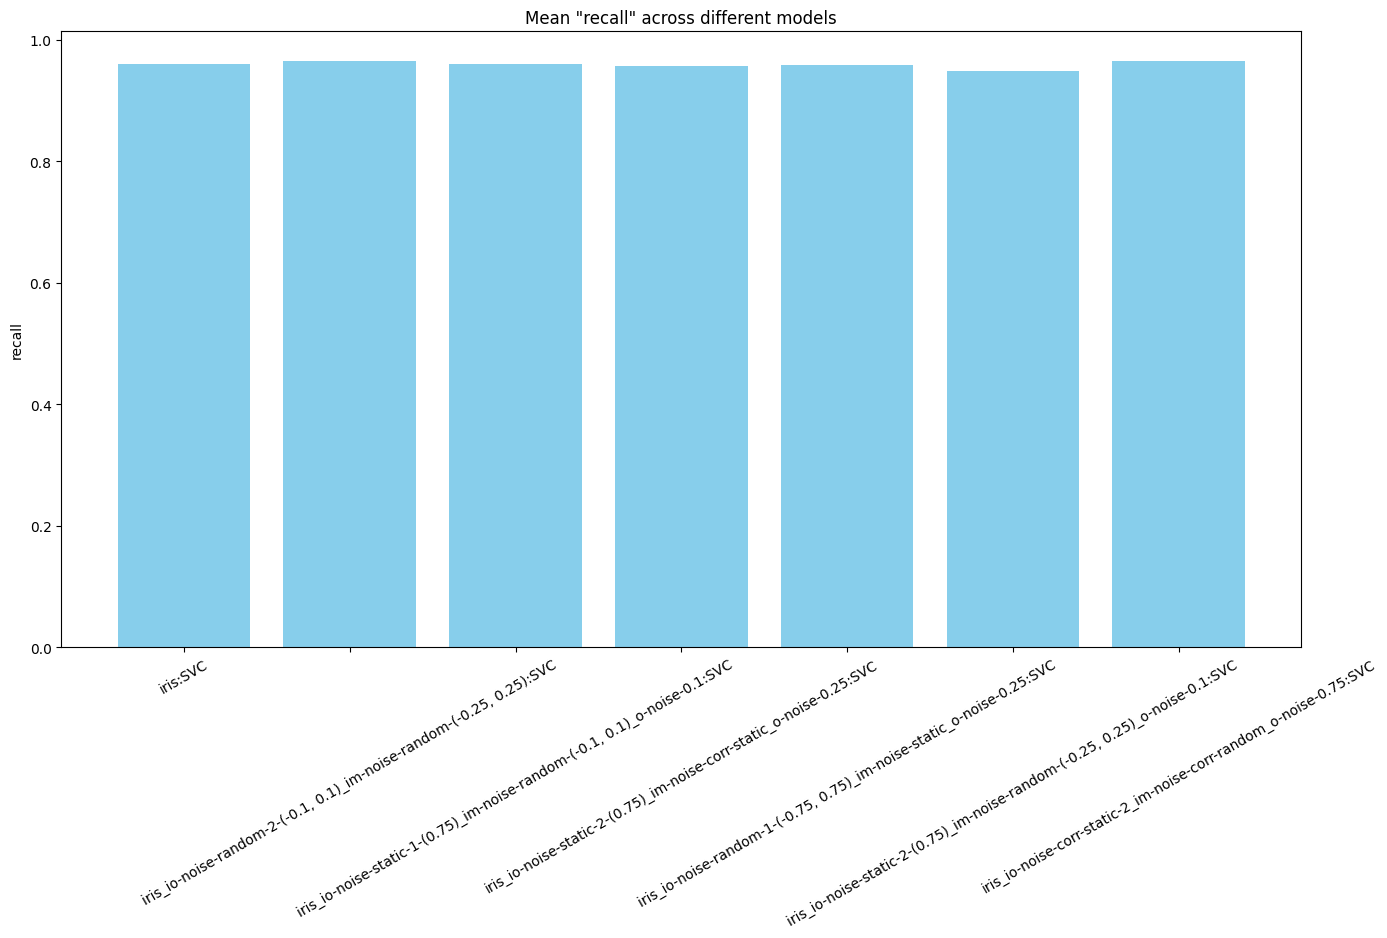

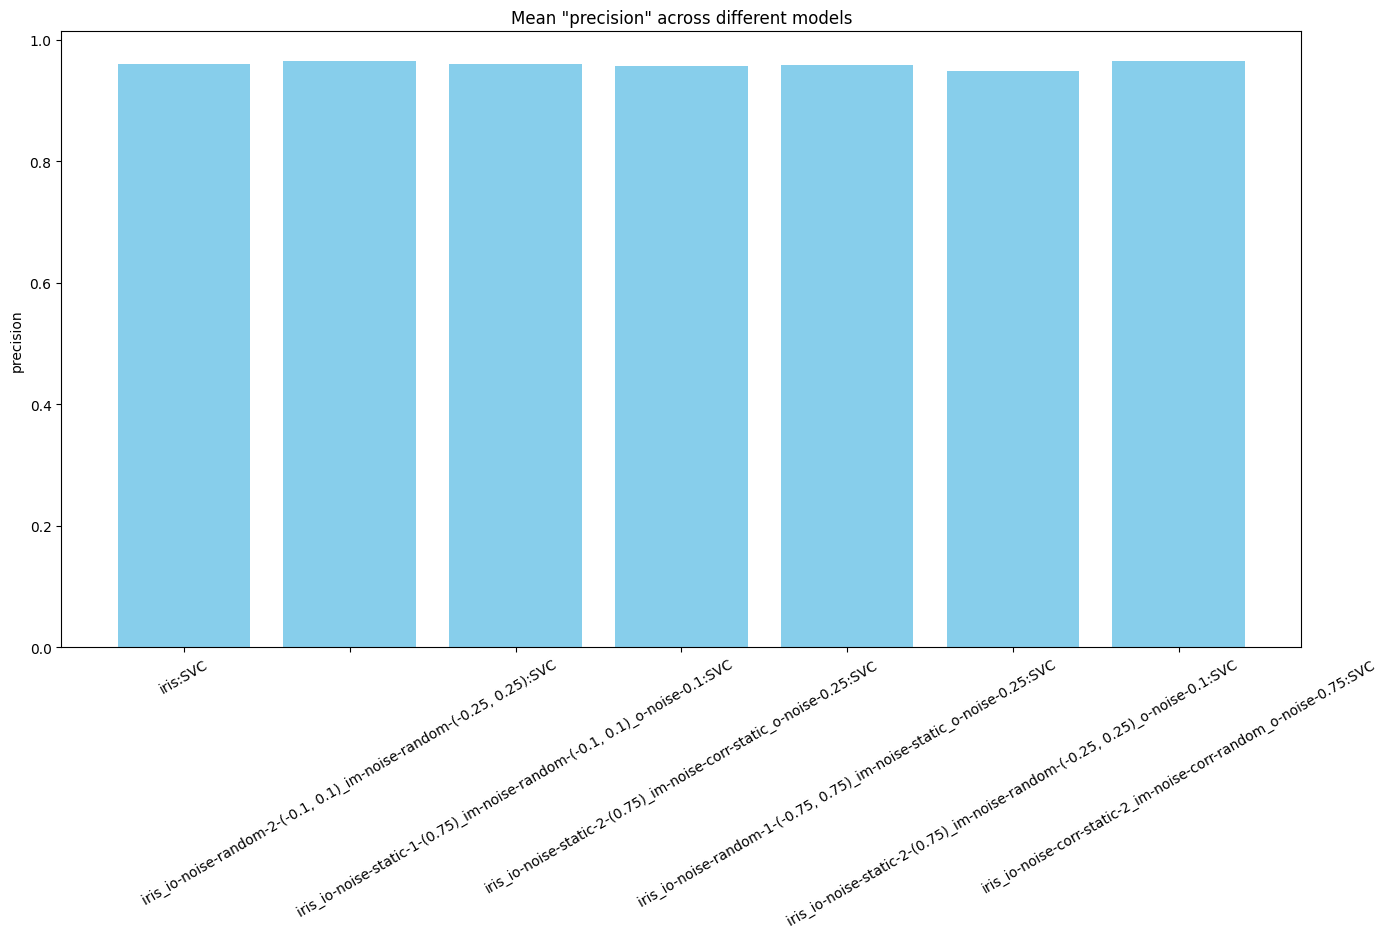

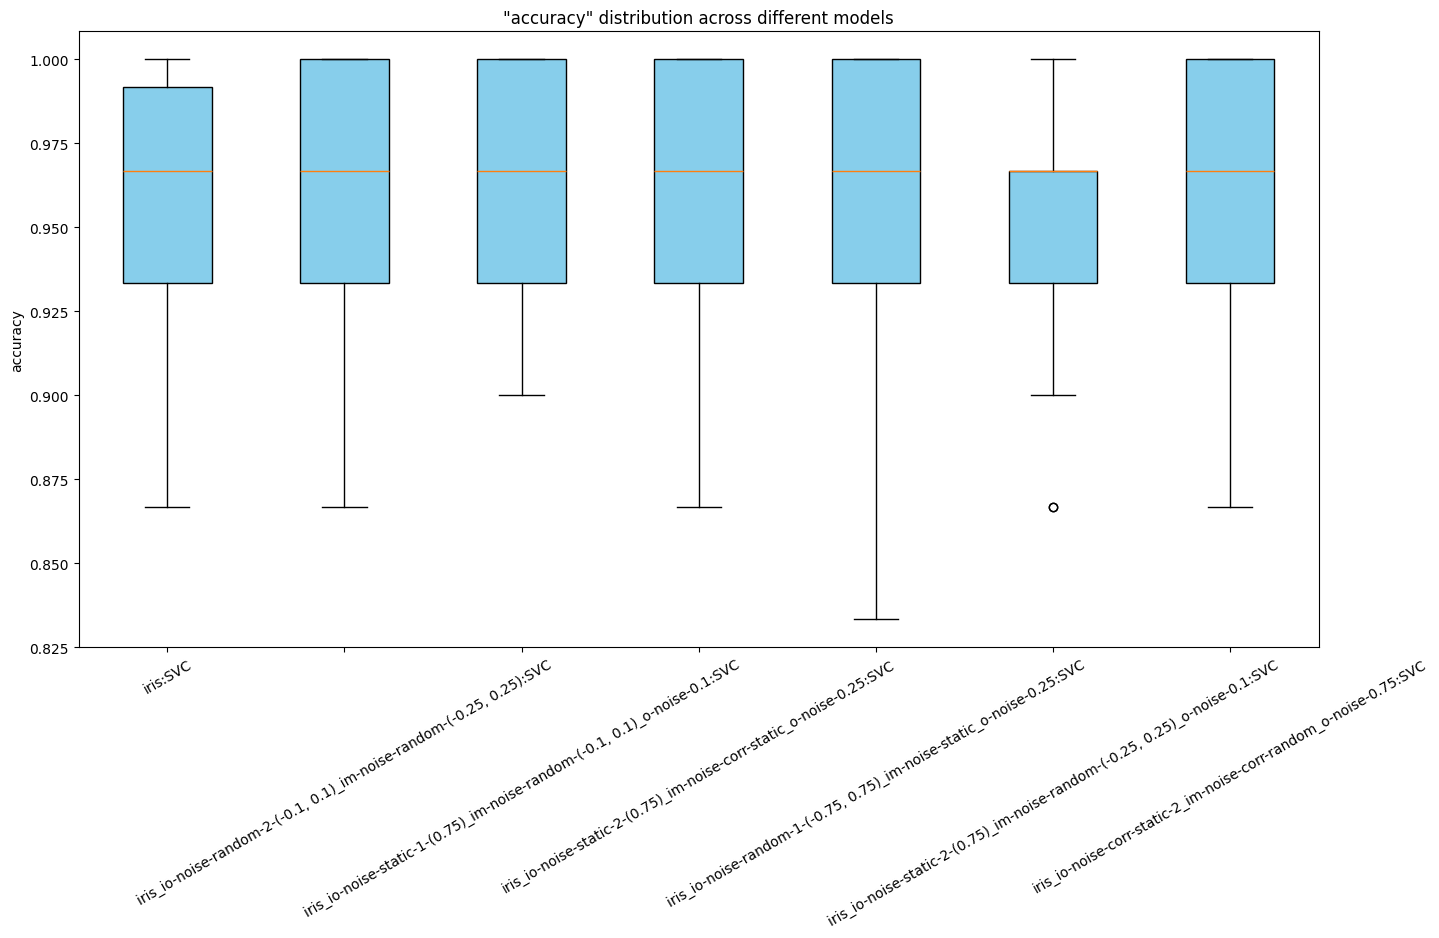

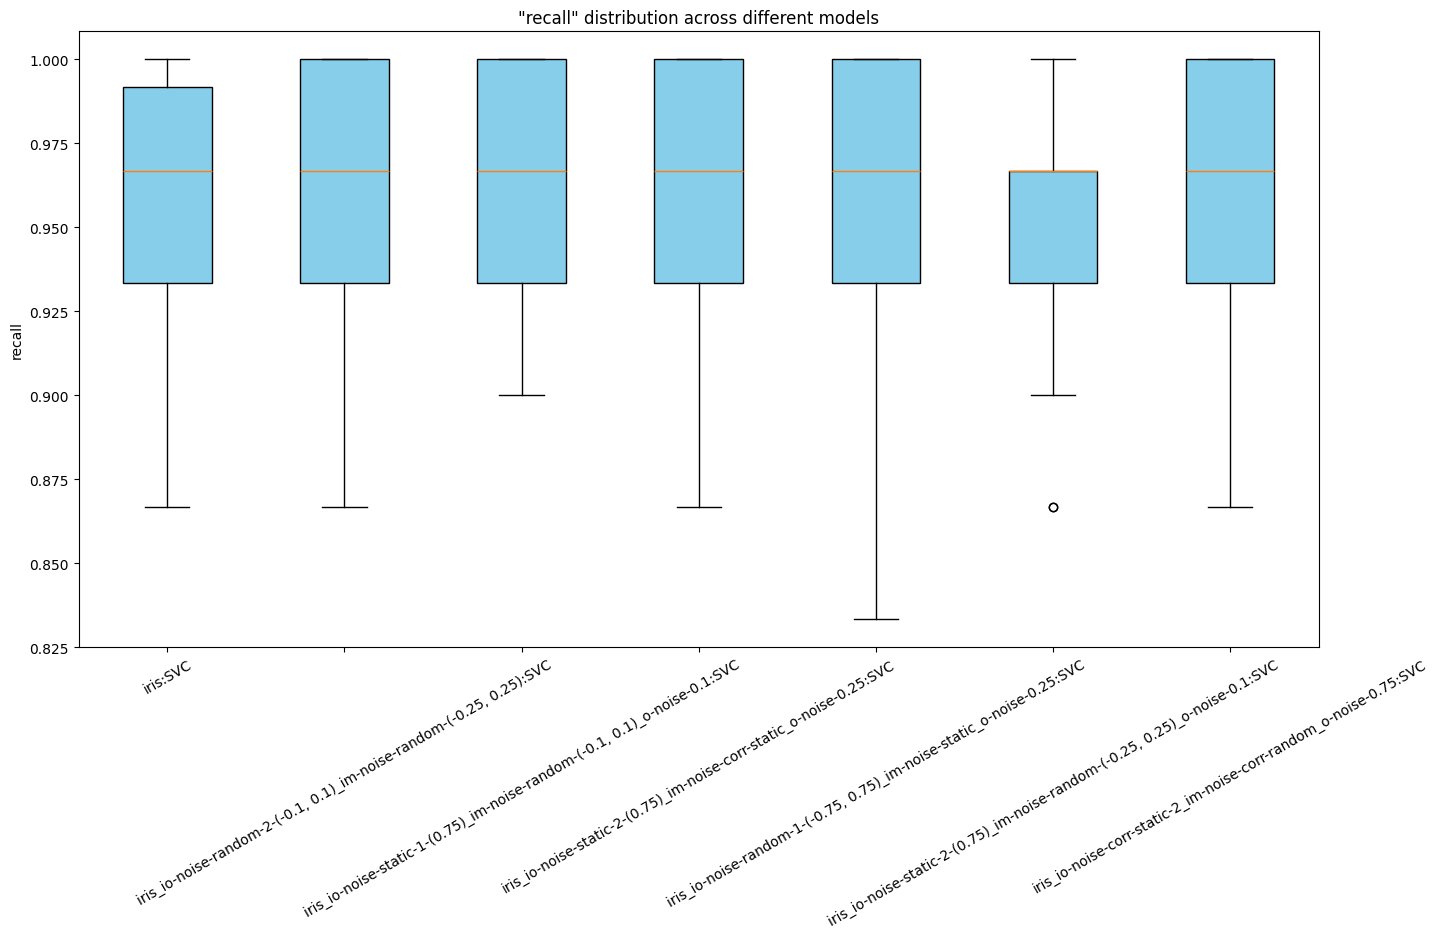

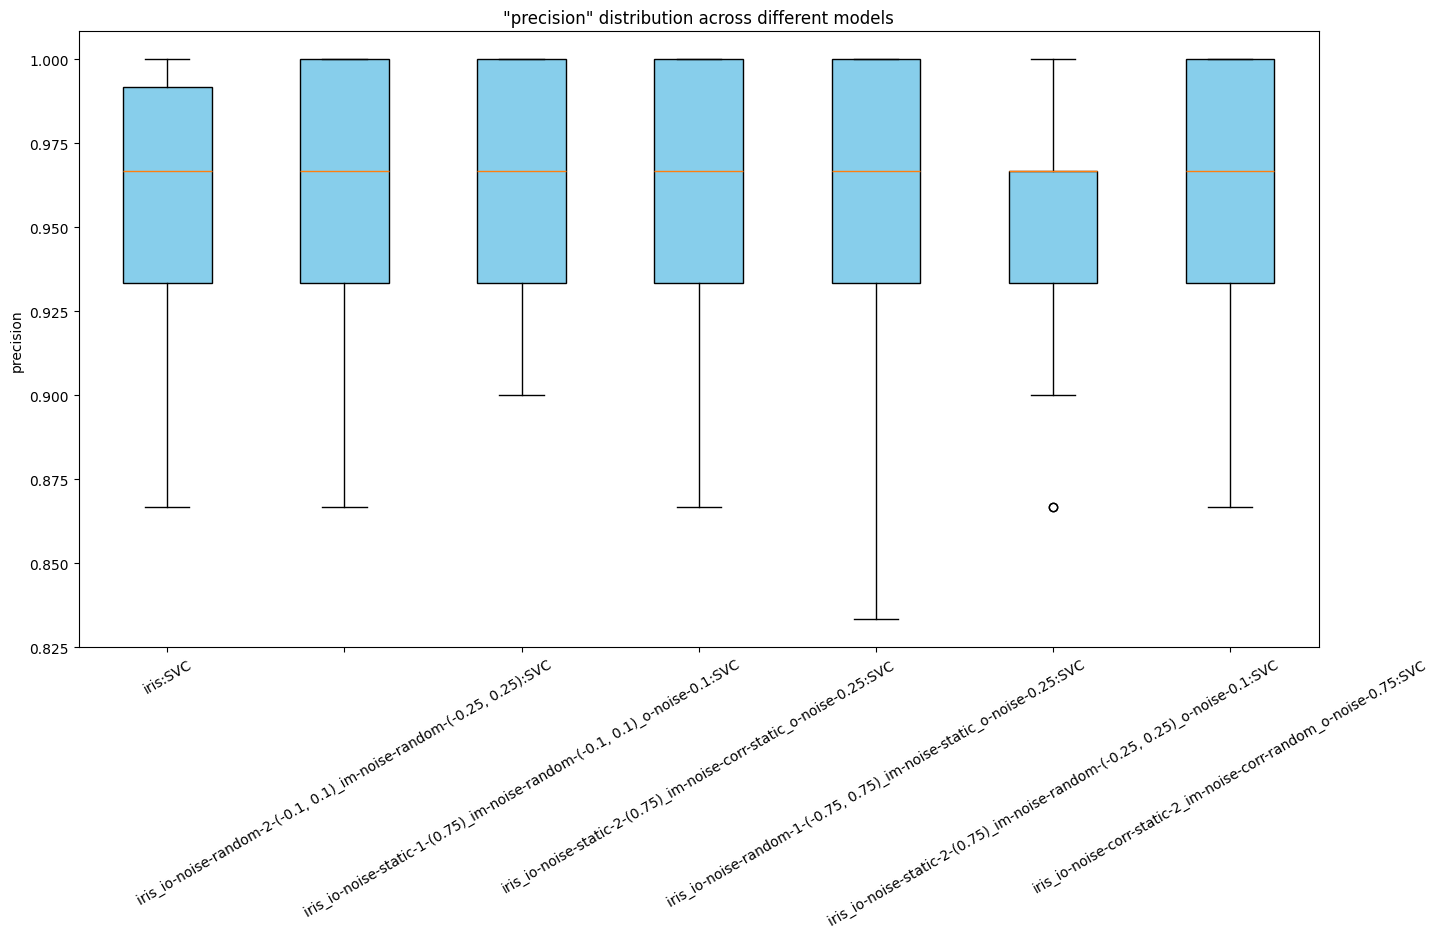

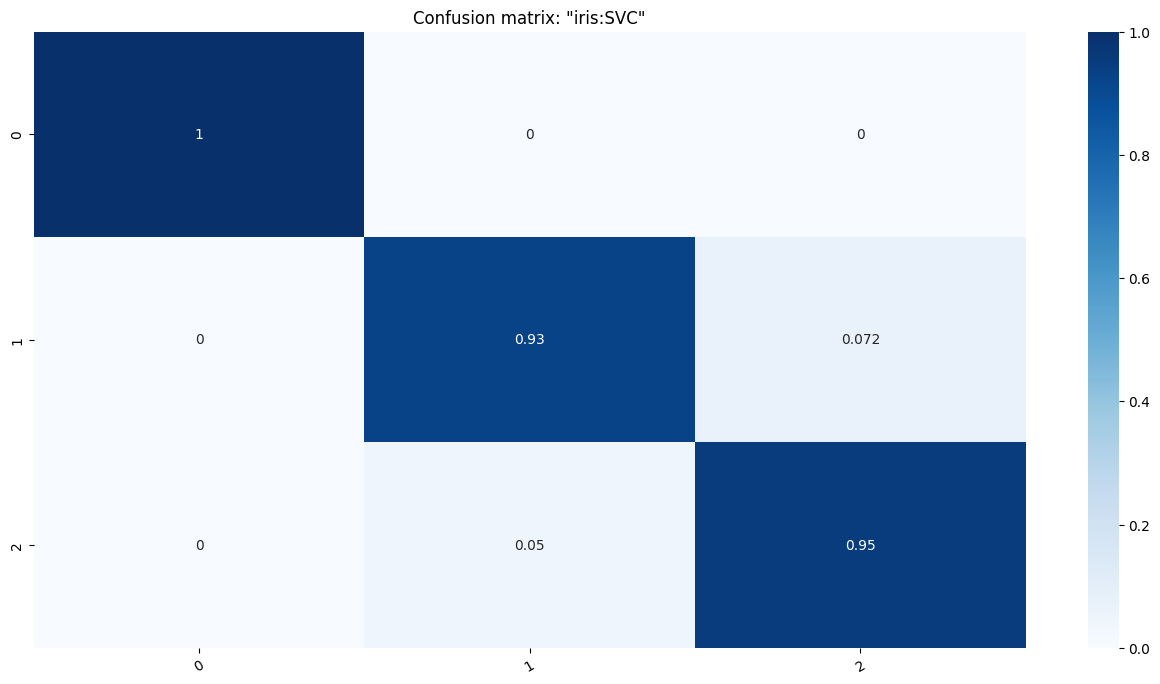

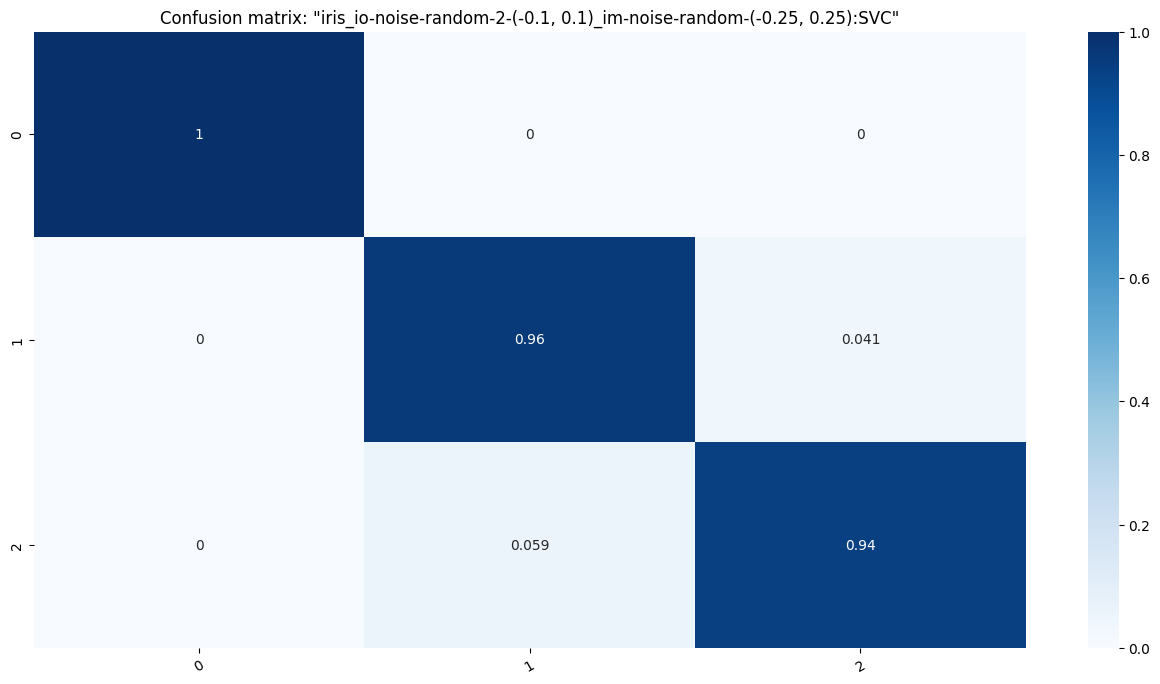

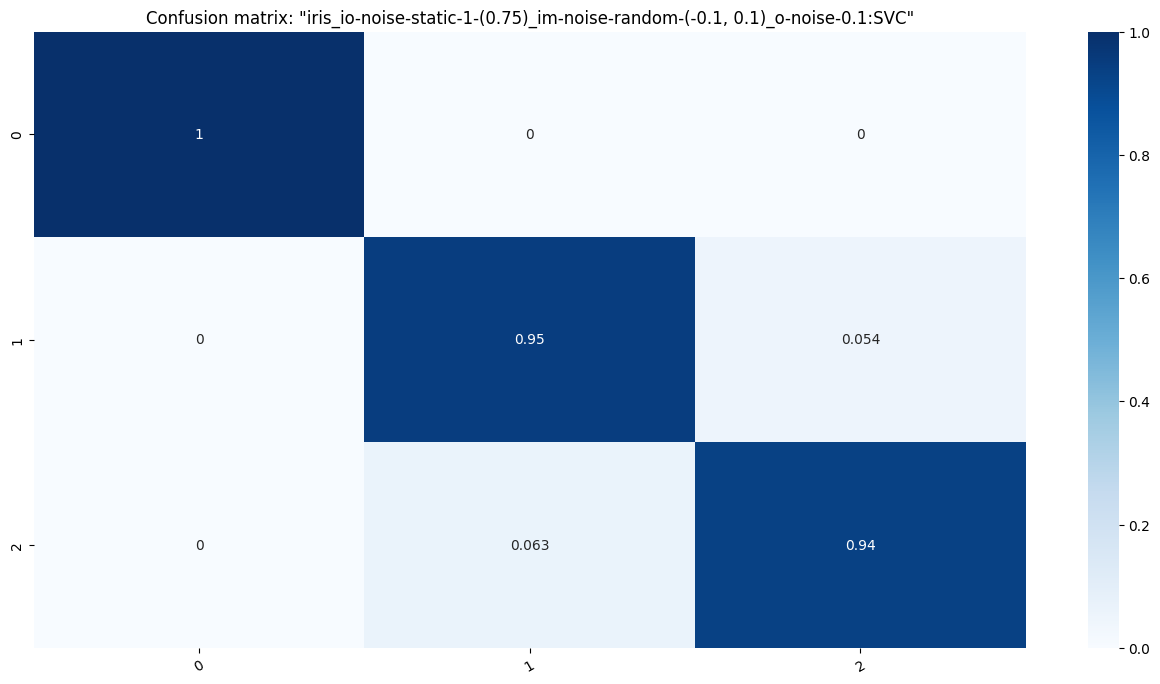

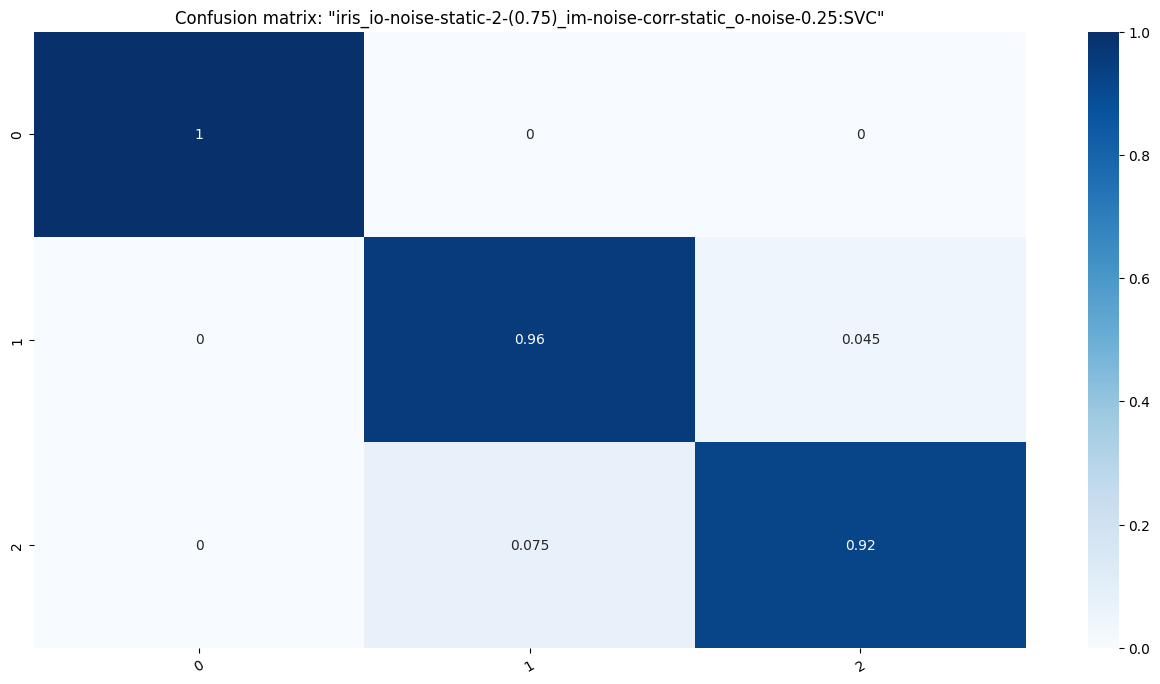

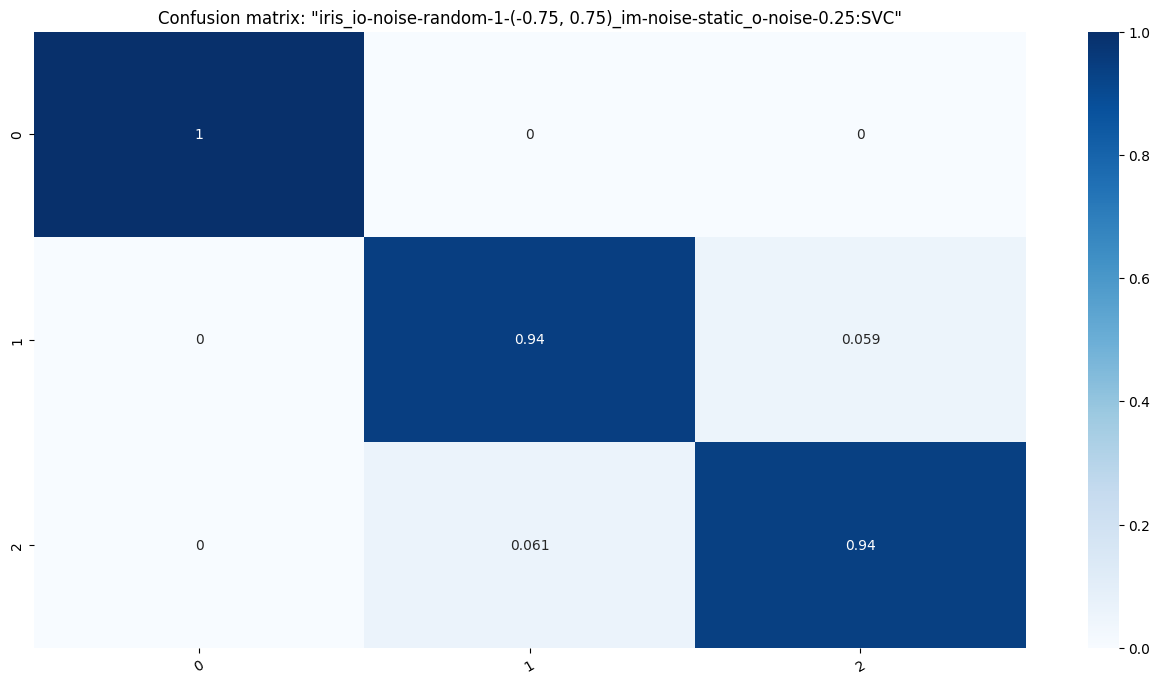

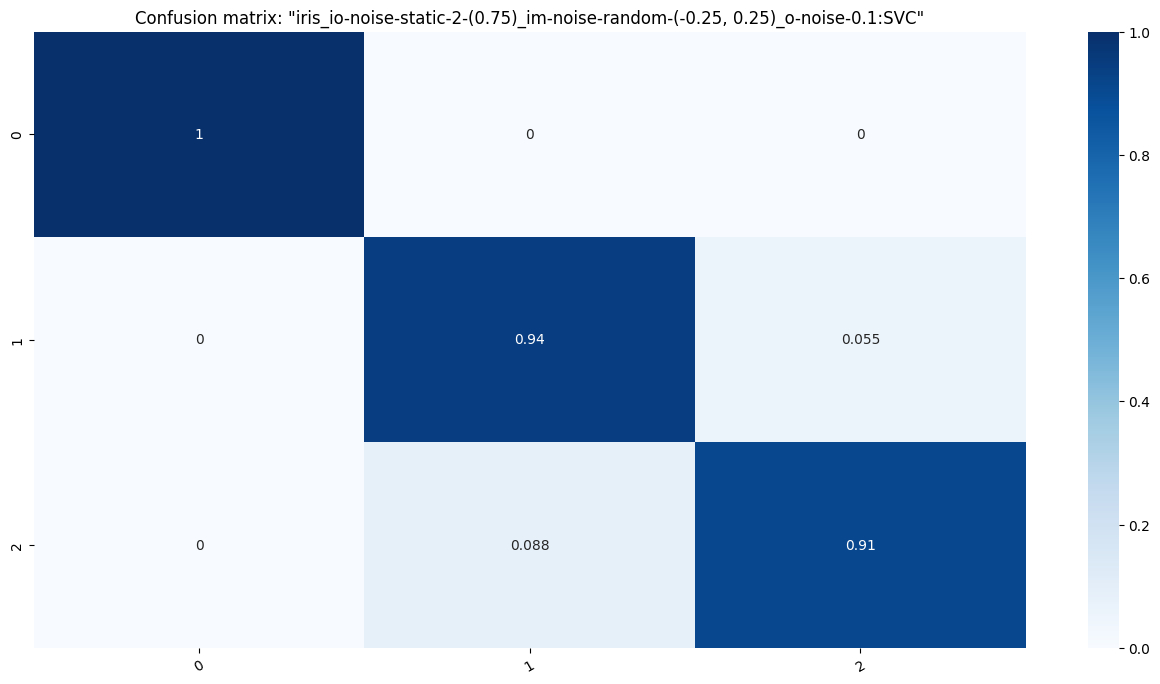

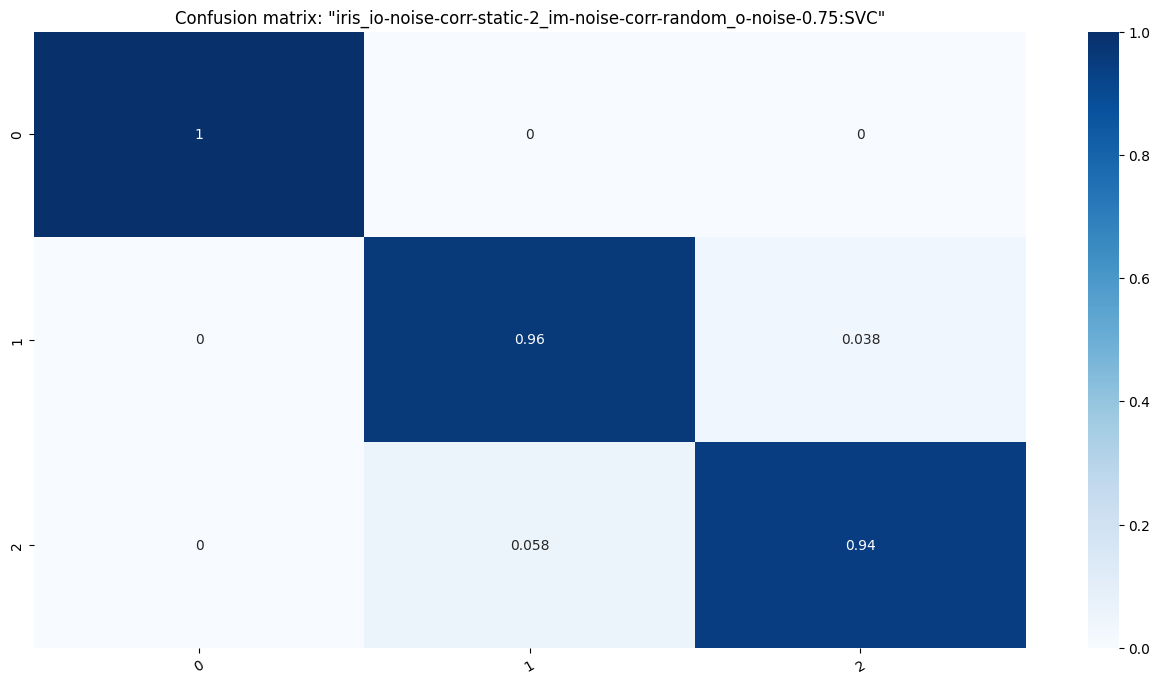

In [54]:
import numpy as np

print(f"Datasets: {datasets}")
for dataset in datasets:
  print(f"  - Dataset: {dataset}")
  for model in models:
    print(f"    - Model: {model}")
    partial_summary = {key: value for key, value in summary.items() if key.startswith(dataset) if key.endswith(model)}
    partial_summary.pop(f"{dataset}:{model}")

    partial_summary_keys = np.random.choice(list(partial_summary.keys()), 6, replace=False)

    partial_summary = \
      {
        f"{dataset}:{model}": summary[f"{dataset}:{model}"]
      } | {
        key: summary[key] for key in partial_summary_keys
      }
    visualize_metrics(partial_summary)


Na części zestawu danych można zauważyć, że wraz ze zmianą parametryzacji faktycznie zmienia się jakość klasyfikacji. Widać, również że dodanie szumu obniża jakość klasyfikacji, ale nie zawsze. W niektórych przypadkach dodanie szumu pozostawia jakość klasyfikacji na zbliżonym poziomie, lub czasami większy.

Datasets: ['wine', 'iris']
  - Dataset: wine
    - Model: SVC


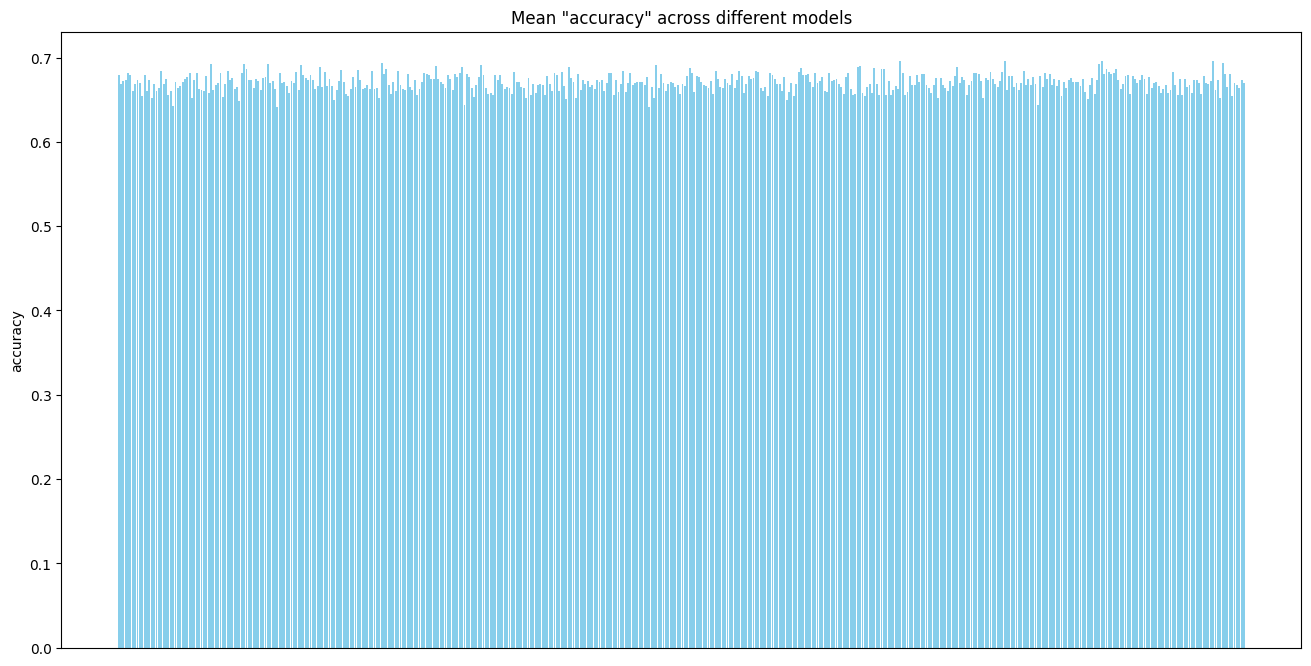

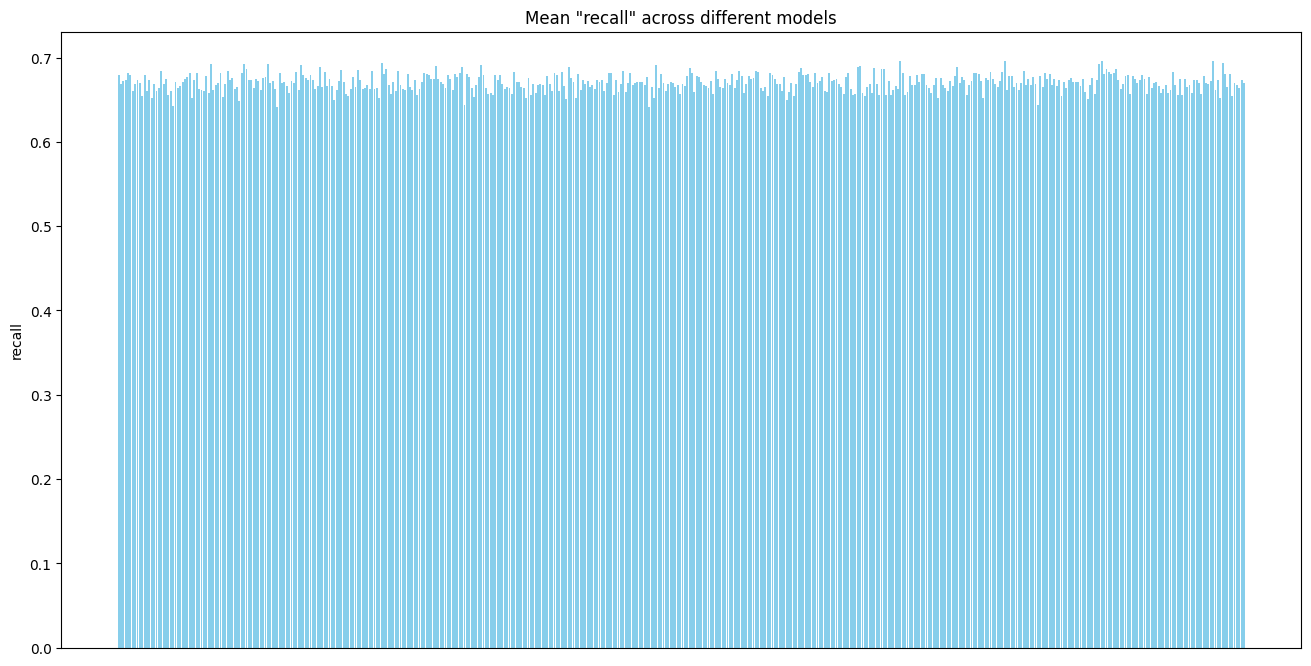

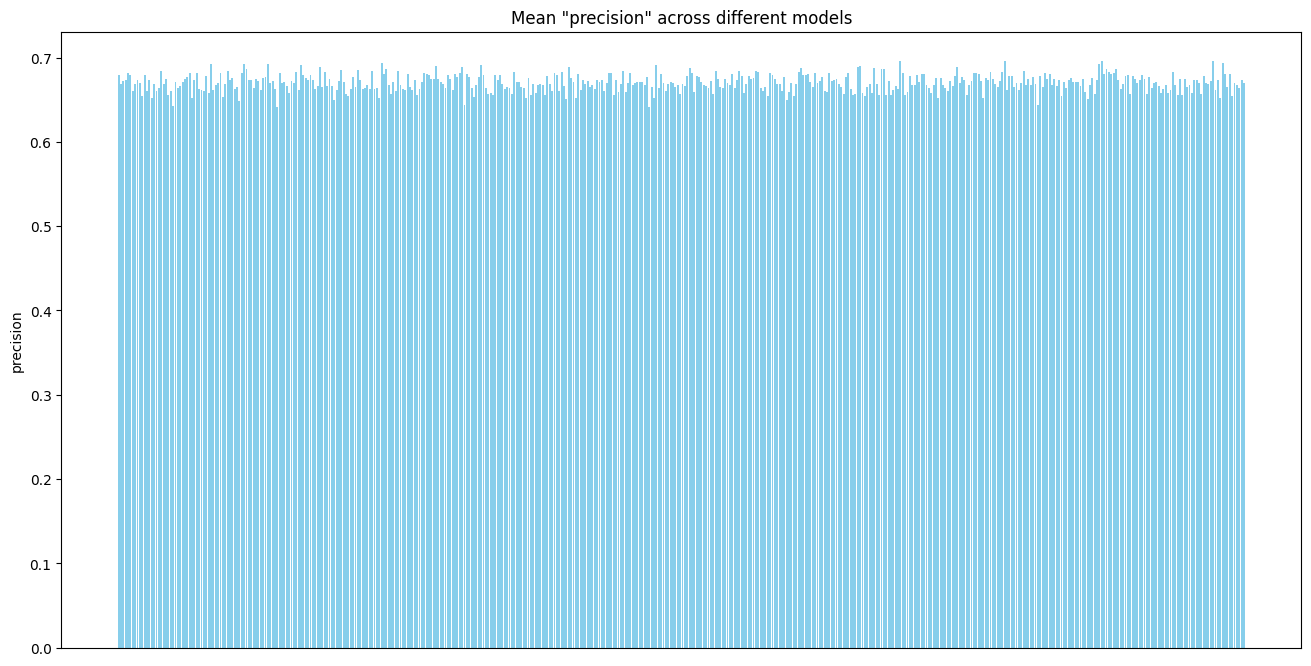

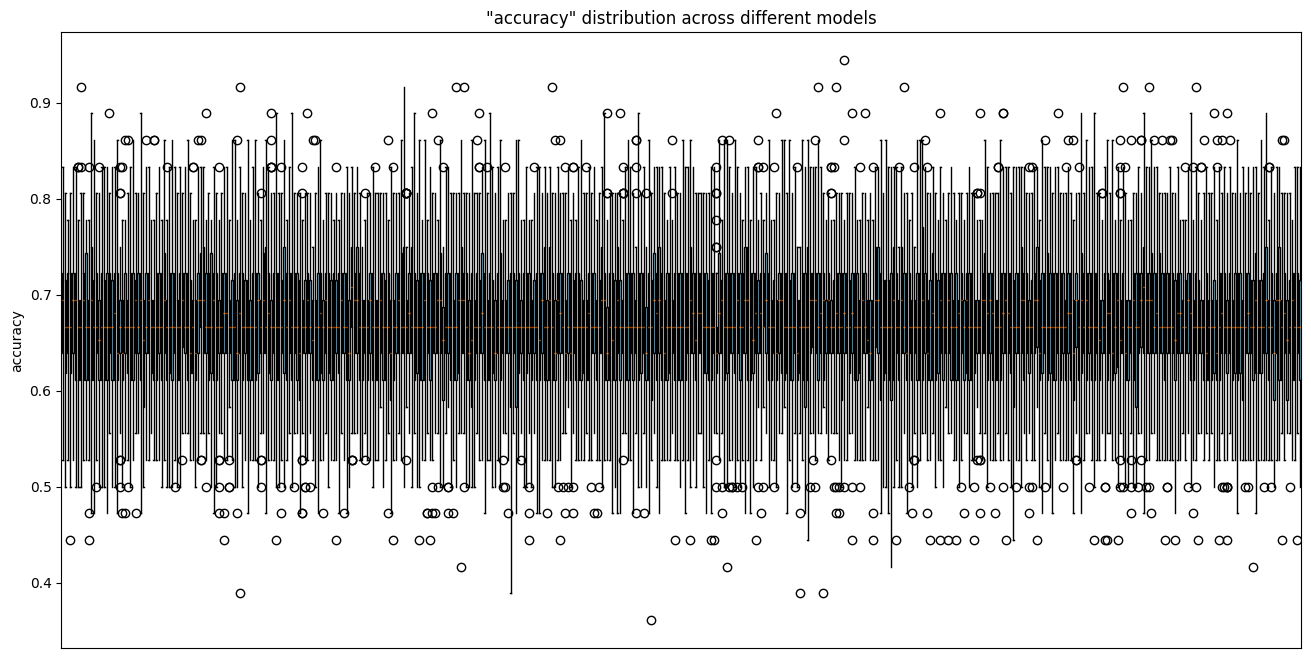

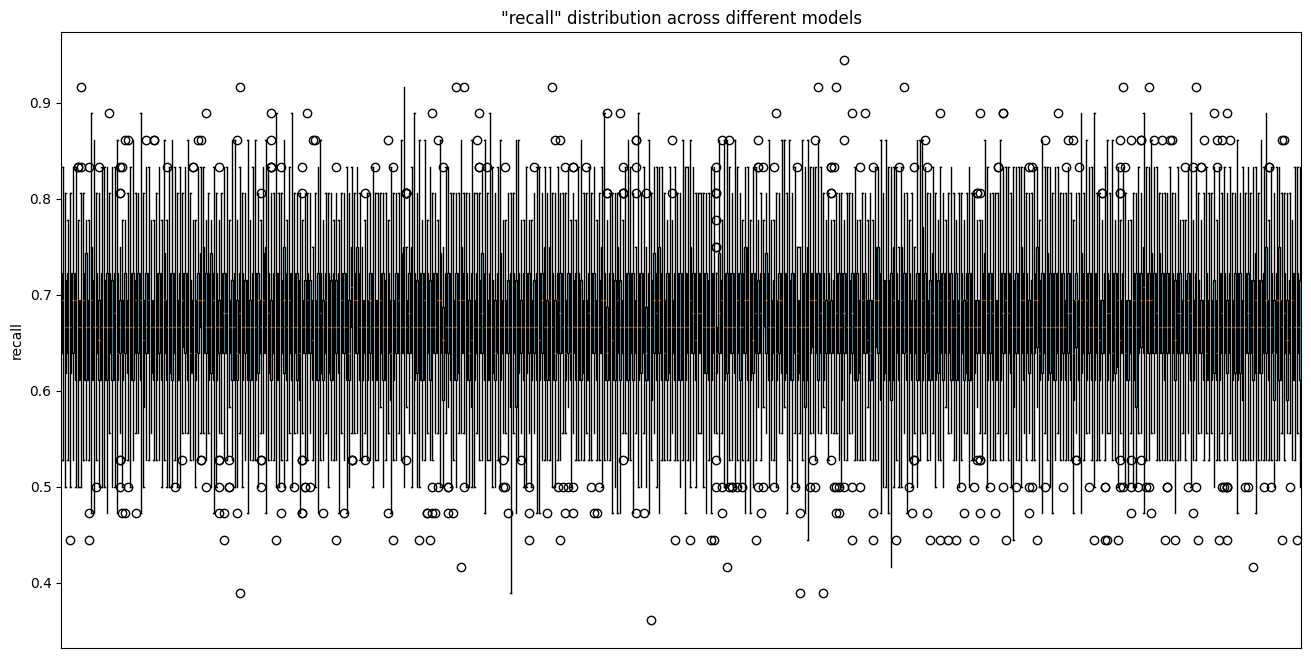

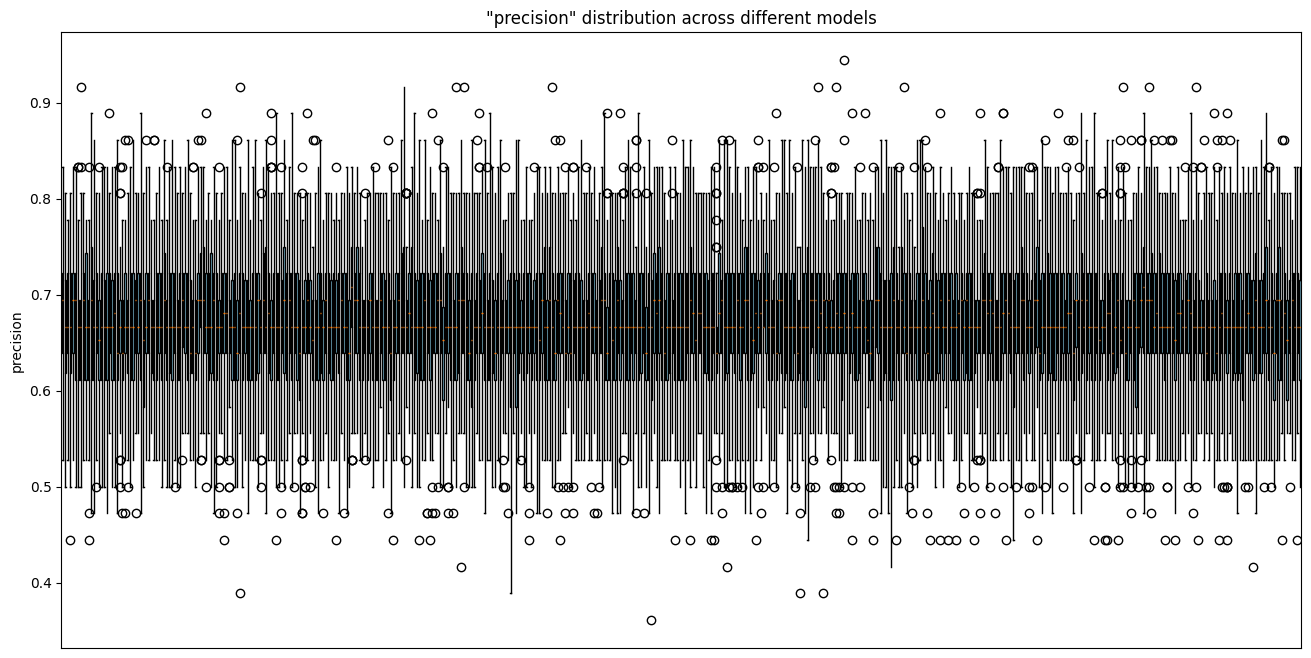

  - Dataset: iris
    - Model: SVC


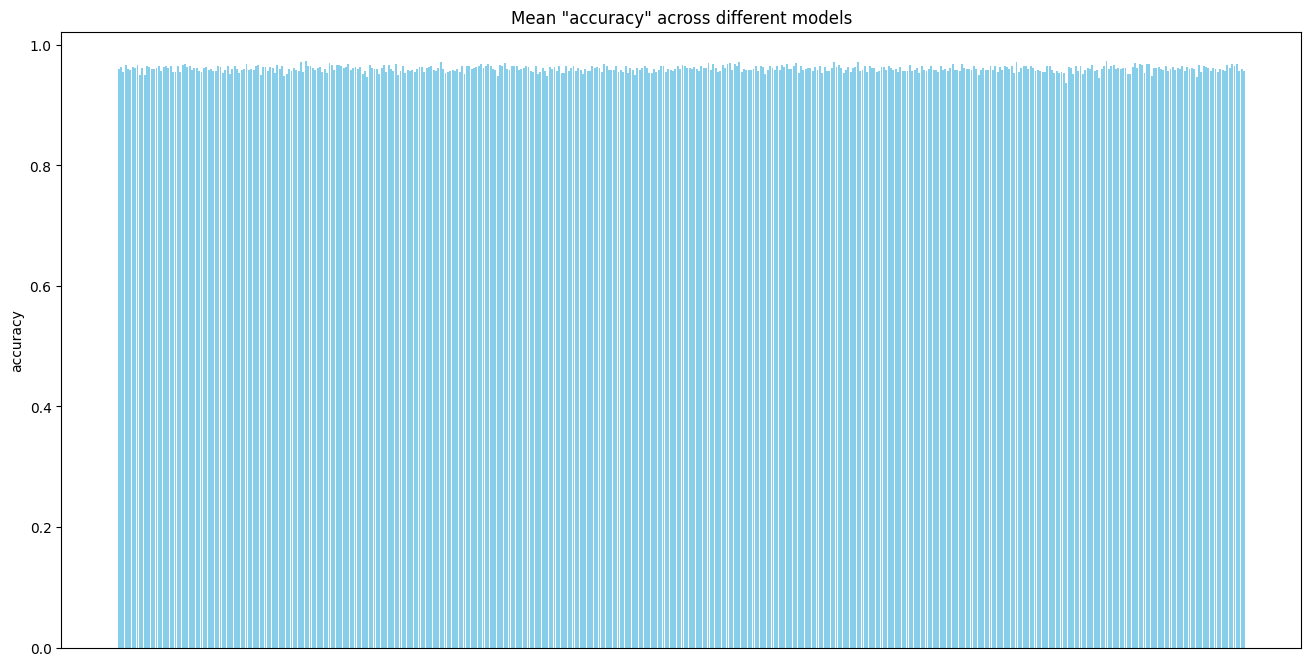

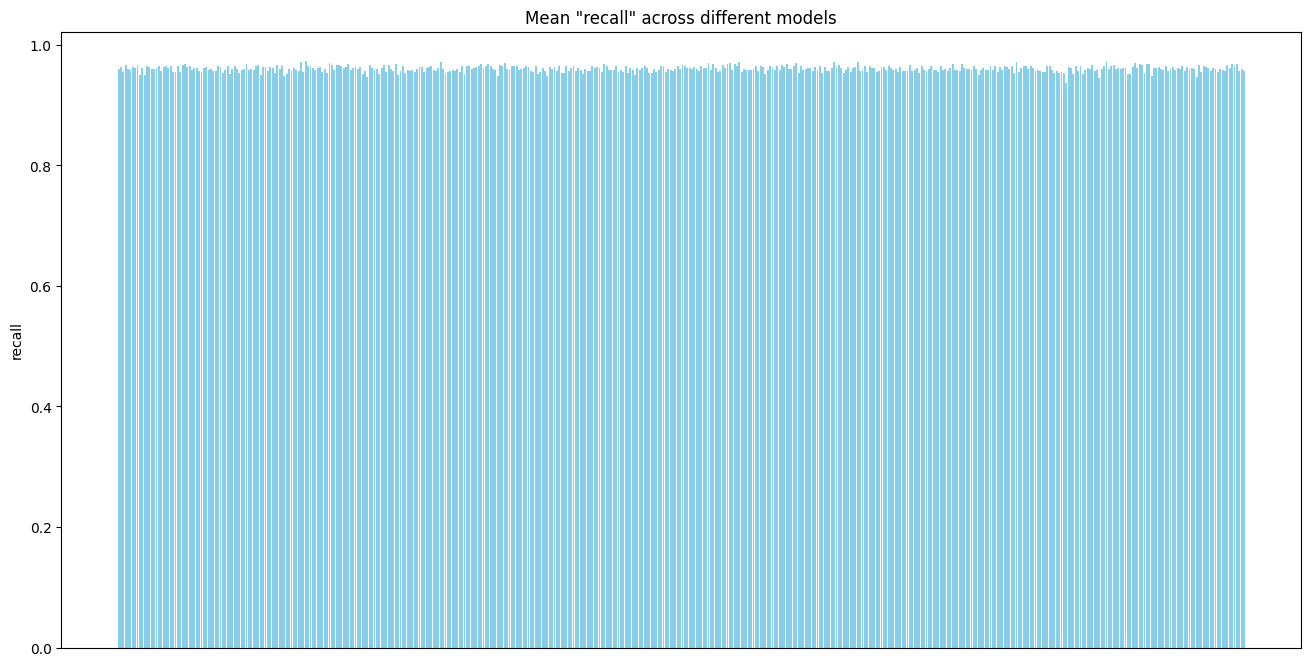

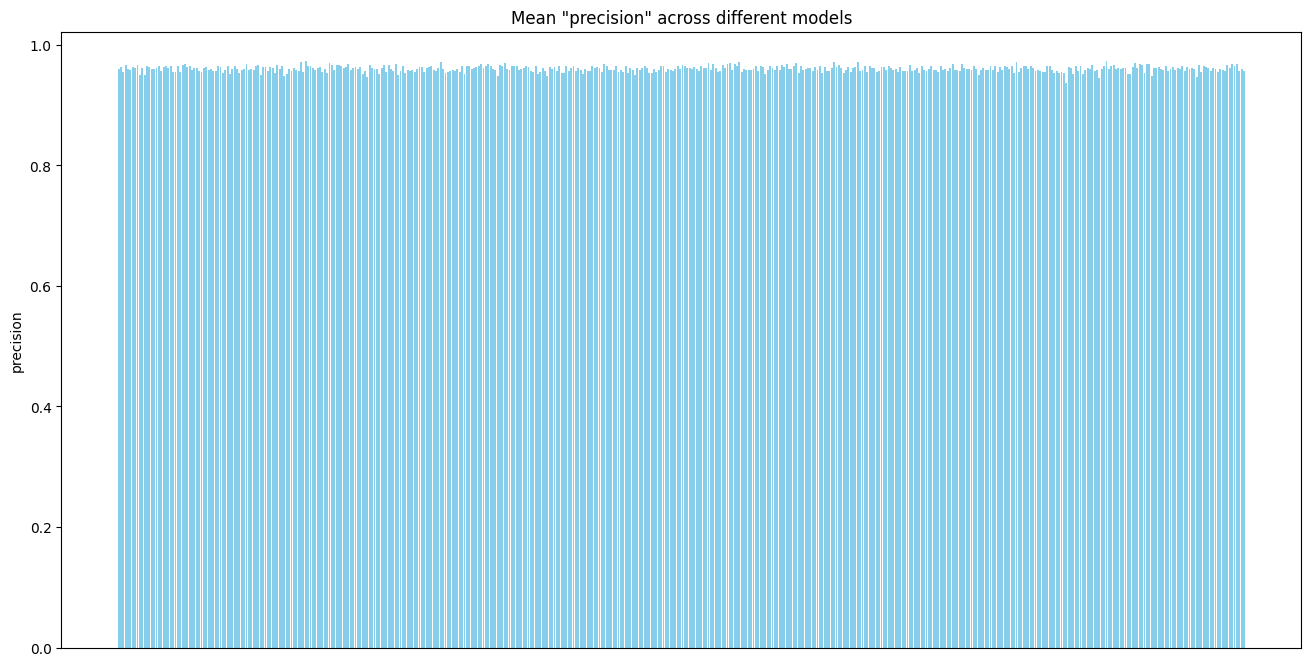

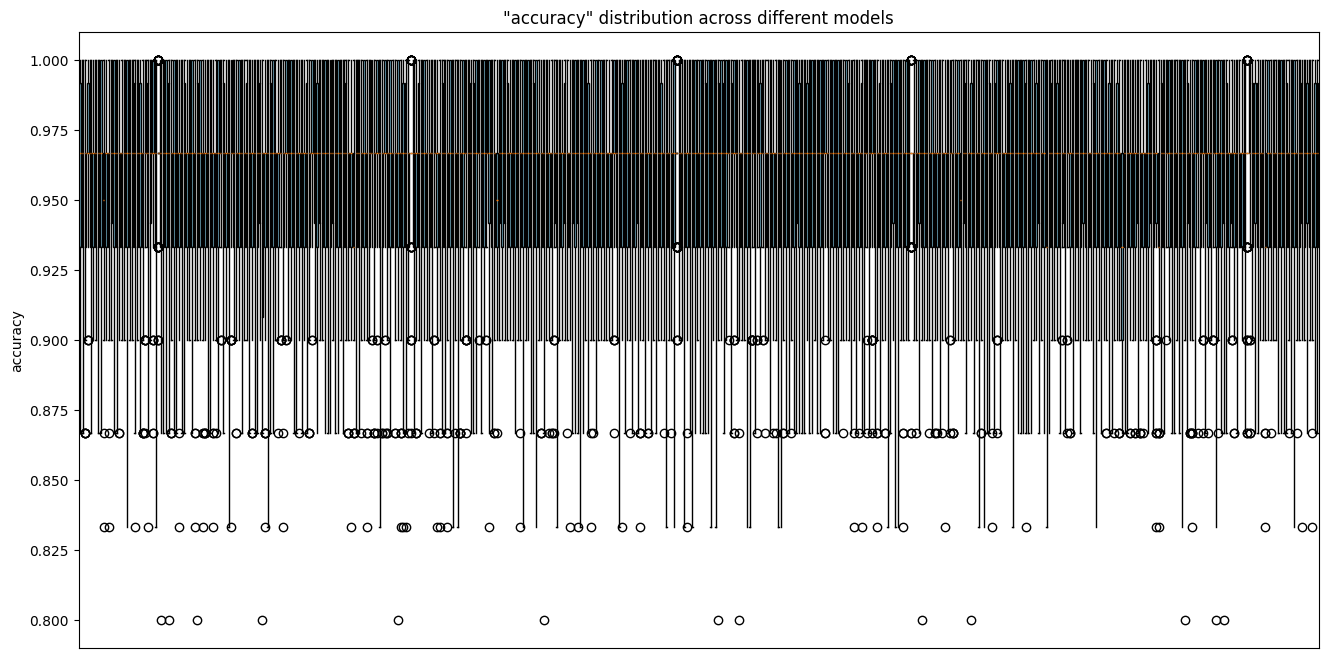

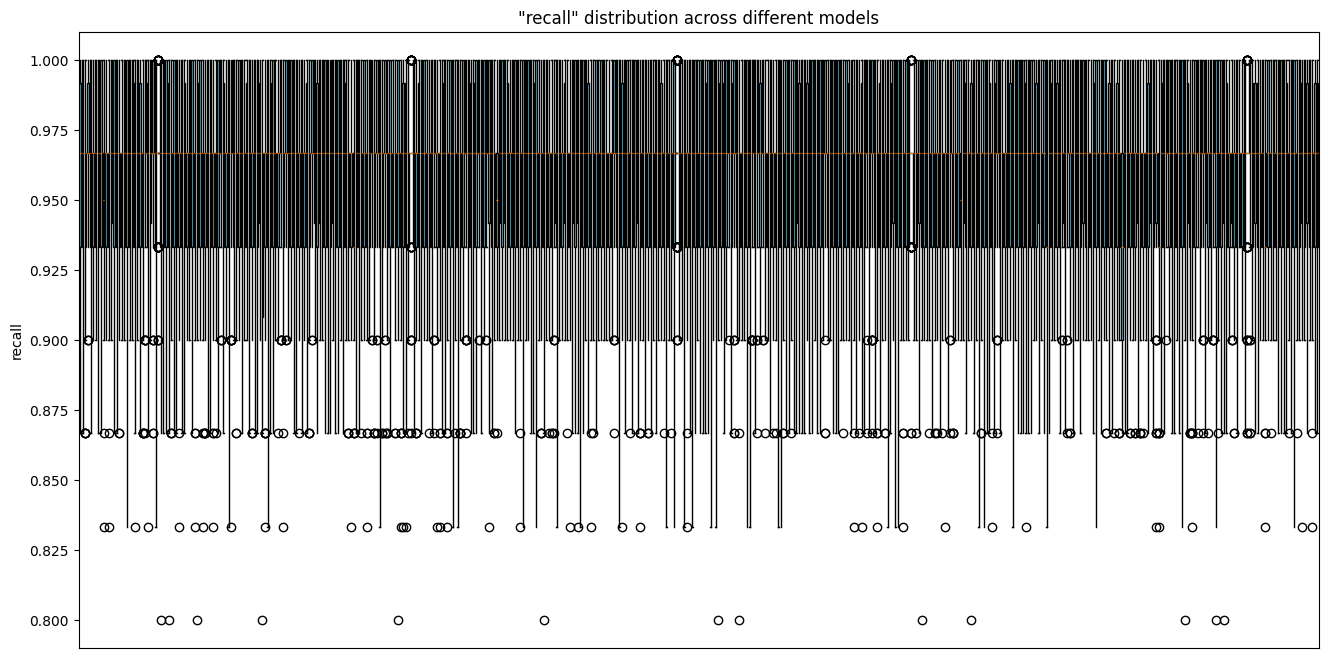

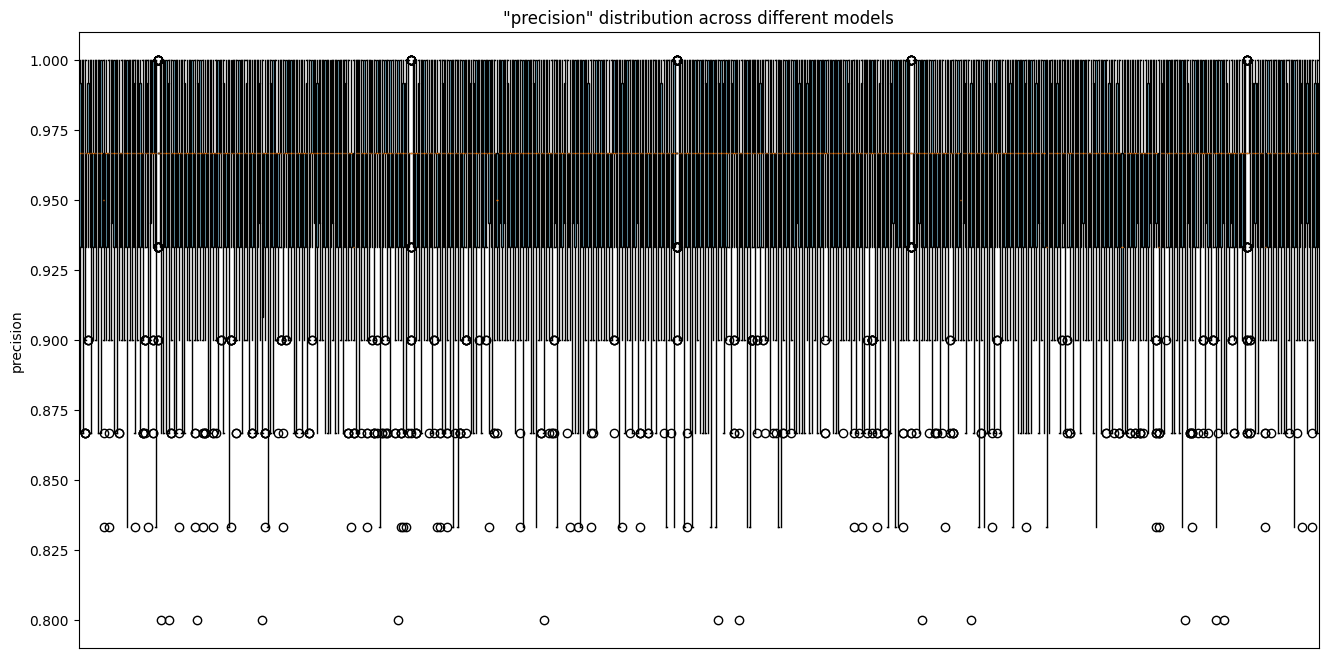

In [55]:
print(f"Datasets: {datasets}")
for dataset in datasets:
  print(f"  - Dataset: {dataset}")
  for model in models:
    print(f"    - Model: {model}")
    partial_summary = {key: value for key, value in summary.items() if key.startswith(dataset) if key.endswith(model)}

    visualize_metrics(partial_summary)


Na pełnym zestawie danych ewidentnie można zauważyć, że faktycznie wraz ze zmianą parametryzacji zmienia się jakość klasyfikacji. Ponownie widać, że dodanie szumu obniża jakość klasyfikacji, ale nie zawsze. W niektórych przypadkach dodanie szumu pozostawia jakość klasyfikacji na zbliżonym poziomie. Najwyższa różnica jest również widoczna i jest powiązana z szumem na etykietach.

## Testy korelacji między cechami, a wynikami

Na podstawie wyników, dokonałem, testów, na których można zobaczyć jaki wpływ ma modyfikacja poszczególnych cech na wynik klasyfikacji. Implementacja wewnątrz metody `visualize_correlation`. z powodu ograniczeń tak samo jak wcześniej ograniczyłem się do 6 wyników i głównego, czasami test jest znaczący, a czasami nie, zależnie od modelu i zestawu danych. Jednak samo powstawanie znaczących testów jest ciekawe. 

In [56]:
import numpy as np

print(f"Datasets: {datasets}")
for dataset in datasets:
  print(f"  - Dataset: {dataset}")
  for model in models:
    print(f"    - Model: {model}")
    partial_summary = {key: value for key, value in summary.items() if key.startswith(dataset) if key.endswith(model)}
    partial_summary.pop(f"{dataset}:{model}")

    partial_summary_keys = np.random.choice(list(partial_summary.keys()), 6, replace=False)

    partial_summary = \
      {
        f"{dataset}:{model}": summary[f"{dataset}:{model}"]
      } | {
        key: summary[key] for key in partial_summary_keys
      }
    visualize_correlation(partial_summary)


Datasets: ['wine', 'iris']
  - Dataset: wine
    - Model: SVC
Correlation:wine_im-noise-random-(-0.1, 0.1):SVC: 0.16882710138597012, p-value: 0.24118523204383646
Correlation p-value: 0.24118523204383646
- No significant correlation: wine_im-noise-random-(-0.1, 0.1):SVC
- Statistical power: 0.6850230386480017
- Insufficient statistical power: wine_im-noise-random-(-0.1, 0.1):SVC

Correlation:wine_io-noise-random-1-(-0.1, 0.1)_o-noise-0.75:SVC: -0.2100739329045796, p-value: 0.14311981432197976
Correlation p-value: 0.14311981432197976
- No significant correlation: wine_io-noise-random-1-(-0.1, 0.1)_o-noise-0.75:SVC
- Statistical power: 1.0
- Sufficient statistical power: wine_io-noise-random-1-(-0.1, 0.1)_o-noise-0.75:SVC

Correlation:wine_io-noise-random-1-(-0.75, 0.75)_im-noise-random-(-0.25, 0.25)_o-noise-0.1:SVC: -0.0439660285292346, p-value: 0.7617601734871816
Correlation p-value: 0.7617601734871816
- No significant correlation: wine_io-noise-random-1-(-0.75, 0.75)_im-noise-random-(-

## Wnioski

Po analizę korelacji między cechami a wynikami i z wykresów wizualicyjnych, widać, że w części przypadków dodanie szumu obniża trafność klasyfikacji i faktycznie wpływa na jakość wytrenowanego modelu, ale zaskaoczeniem jest to, że nie zawsze, a wręcz przeciwnie, poprawia jakość klasyfikacji. Testy są niekonkluzyjne, jednak Może to wynikać z faktu, że dodanie szumu pomaga w generalizacji modelu, ale nie zawsze. Generalizacja może pochodzić z tego, że dodając szum modelujemy nieistniejące cechy w zbiorze, które w prawdziwym świecie mogą być istotne.

Niemniej, wnioski potwierdzają moje założenia, że dodanie szumu obniża jakość klasyfikacji, ale jednak nie zawsze, a szum na wyjściu czasem podwyższa znacząco jakość klasyfikacji.

Jako dalsze kroki, możnaby było zastosować techniki regularyzacji, ( PCA, L1, L2 ), które mogą wpłynąć dosyć usunięcie szumów, a także zastosować bardziej zaawansowane techniki szumienia danych, które mogą pomóc w lepszym generalizowaniu modelu.
